In [1]:
# Standard library imports
import os
import random
import gc
import copy

# Third-party library imports
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 12.1
cuDNN Version: 90100
PyTorch Version: 2.5.1+cu121
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA A100-PCIE-40GB MIG 7g.40gb
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [4]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Create variable to store dataset name
dataset_name = 'boston'
results_path = f'logs/Regression/{dataset_name}/CNN+MLP_Regression'

In [6]:
df = pd.read_csv(f"./Dataset/Regression/{dataset_name}.csv")

In [7]:
df.shape

(506, 14)

In [8]:
# Drop the second-to-last column if MIMO
# df = df.drop(df.columns[-2], axis=1)

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## LOAD AND PREPROCESS

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.generateImages_fit(X_train, f'{images_folder}/train')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.generateImages_pred(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.generateImages_fit(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [11]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape):
        super(Model1, self).__init__()
        
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the size of the flattened CNN output
        cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(16 + cnn_output_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
    def forward(self, mlp_input, cnn_input):
        mlp_output = self.mlp_branch(mlp_input)
        cnn_output = self.cnn_branch(cnn_input)
        
        # Concatenate the outputs of CNN and MLP branches
        concat_output = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final MLP layers
        final_output = self.final_mlp(concat_output)
        
        return final_output

In [12]:
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape):
        super(Model2, self).__init__()
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(attributes, imgs_shape)
        
        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def _get_flat_size(self, attributes, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_mlp_input = torch.zeros(1, attributes)
        dummy_cnn_input = torch.zeros(1, *imgs_shape)
        
        mlp_output = self.mlp_branch(dummy_mlp_input)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        
        return cnn_output.size(1)
    
    def forward(self, mlp_input, img_input):
        # CNN branch
        cnn_output = self.cnn_branch(img_input)
        
        # MLP branch
        mlp_output = self.mlp_branch(mlp_input)

        # Combine CNN and MLP outputs
        merged = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final layers
        final_output = self.final_mlp(merged)
        return final_output

In [13]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape):
        super(Model3, self).__init__()
        # The formula to calculate the padding is:
        # padding = (kernel_size - 1) // 2
        
        dropout = 0.1
        
        # MLP branch 1
        self.mlp1 = nn.Sequential(
            nn.Linear(attributes, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(dropout)
        )
        
        # MLP branch 2
        self.mlp2 = nn.Sequential(
            nn.Linear(attributes, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(dropout)
        )

        # CNN+MLP branch 1
        self.branch_1 = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout)
        )

        # CNN+MLP branch 2
        self.branch_2 = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Dropout(dropout)
        )

        self.flatten = nn.Flatten()
        
        self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
        
        # CNN layers
        self.cnn_layers = nn.Sequential(
            nn.Linear(self.cnn_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(attributes, imgs_shape)
        
        # Dense layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flat_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(8, 1)
        )

    def _get_flat_size(self, attributes, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_mlp_input = torch.zeros(4, attributes)
        dummy_cnn_input = torch.zeros(4, *imgs_shape)

        # MLP branches
        mlp1_out = self.mlp1(dummy_mlp_input)
        mlp2_out = self.mlp2(dummy_mlp_input)
        mlp_output = torch.cat((mlp1_out, mlp2_out), dim=1)

        # CNN branches
        branch_1_out = self.branch_1(dummy_cnn_input)
        branch_2_out = self.branch_2(dummy_cnn_input)
        cnn_output = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened_cnn = self.flatten(cnn_output)
        flattened_cnn = self.cnn_layers(flattened_cnn)

        # Concatenate MLP and flattened CNN outputs
        concat_out = torch.cat((mlp_output, flattened_cnn), dim=1)

        return concat_out.shape[1]
    
    def _get_cnn_size(self, attributes, imgs_shape):
        dummy_cnn_input = torch.zeros(4, *imgs_shape)
        # CNN branches
        branch_1_out = self.branch_1(dummy_cnn_input)
        branch_2_out = self.branch_2(dummy_cnn_input)
        cnn_output = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened_cnn = self.flatten(cnn_output)
        
        return flattened_cnn.shape[1]
        
    def forward(self,  attributes, imgs_shape):
        # MLP branch
        mlp1_out = self.mlp1(attributes)
        mlp2_out = self.mlp2(attributes)
        mlp_output = torch.cat((mlp1_out, mlp2_out), dim=1)
        
        # CNN branch
        branch_1_out = self.branch_1(imgs_shape)
        branch_2_out = self.branch_2(imgs_shape)
        merged = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened_cnn = self.flatten(merged)
        
        # Process CNN layers
        cnn_output = self.cnn_layers(flattened_cnn)
        
        # Concatenate MLP and CNN outputs
        concat_out = torch.cat((mlp_output, cnn_output), dim=1)
        
        output = self.fc_layers(concat_out)
        return output

## COMPILE AND FIT

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')    

    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/learning_rate_plot.png")
    plt.close()

In [15]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device, weight_decay=weight_decay)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [16]:
import traceback

def try_create_model(model_class, attributes, imgs_shape):
    try:
        model = model_class(attributes, imgs_shape)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [17]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter

def run_lr_finder(model_class, attributes, imgs_shape, dataset_name, name, train_loader, val_loader, num_iter):
    
    class MyTrainDataLoaderIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            # Since the data we want to used are the first two values of
            # `batch_data`, we need to pack them in this format,
            *desired_data, label = batch_data   # desired_data: x, x_embds
            return desired_data, label

    class MyValDataLoaderIter(ValDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            *desired_data, label = batch_data
            return desired_data, label

    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model

        def forward(self, data):
            # Unpack data to the format you need
            x, x_embds = data
            return self.model(x, x_embds)

    # Define the path where the plot will be saved
    save_dir = os.path.join(f"logs/Regression/{dataset_name}/CNN+MLP/{name}")
    save_path = os.path.join(save_dir, 'lr_finder_plot.png')

    # Check if the file already exists
    if not os.path.exists(save_path):
        # Create and train Model
        model = try_create_model(model_class, attributes, imgs_shape)
        
        if model is None:
            return None
        
        # Prepare wrapper for dataloader
        train_loader_wrapper = MyTrainDataLoaderIter(train_loader)
        val_loader_wrapper = MyValDataLoaderIter(val_loader)
        
        # Prepare wrapper for model
        model_wrapper = ModelWrapper(model)
        
        # Move model to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_wrapper = model_wrapper.to(device)
        
        optimizer = optim.AdamW(model_wrapper.parameters(), lr=1e-7, weight_decay=1e-2)
        criterion = nn.MSELoss()
        
        lr_finder = LRFinder(model_wrapper, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader_wrapper, val_loader=val_loader_wrapper, end_lr=1, num_iter=num_iter, step_mode="exp")
        
        axis, lr = lr_finder.plot()
        
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get the figure from the axis and save it
        fig = axis.figure
        fig.savefig(save_path)
        print(f"Plot saved to: {save_path}")
        
        # Close the figure to ensure it's saved properly
        plt.close(fig)
        
        lr_finder.reset()
        print(f"Suggested learning rate: {lr}")
        
        return lr
    else:
        print(f"LR finder plot already exists at {save_path}. Skipping LR finder process.")
        # Load and display the existing image
        img = plt.imread(save_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title("Learning Rate Finder Plot")
        plt.show()
        
        return None  # Or you could return a default learning rate here

# Usage example:
# lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, name, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
def zoom_and_save_images_pixel_replication(input_folder, output_folder, zoom_factor):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with Image.open(input_path) as img:
                # Calculate new size
                new_size = tuple(int(dim * zoom_factor) for dim in img.size)
                
                # Resize image using nearest neighbor interpolation
                resized_img = img.resize(new_size, Image.NEAREST)
                
                # Save resized image
                resized_img.save(output_path)

## EXPERIMENTS

In [19]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [20]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [21]:
batch_size = 32

In [22]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)
# For the Boston dataset, the number of samples is too small for a range test, so the number of epochs is tripled.
num_epochs = num_epochs*3

In [23]:
num_epochs

48

### EXPERIMENT 1: TINTO

In [24]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
name = f"TINTO_blur"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [25]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO_blur/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO_blur/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO_blur/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_blur_Model1/lr_finder_plot.png. Skipping LR finder process.


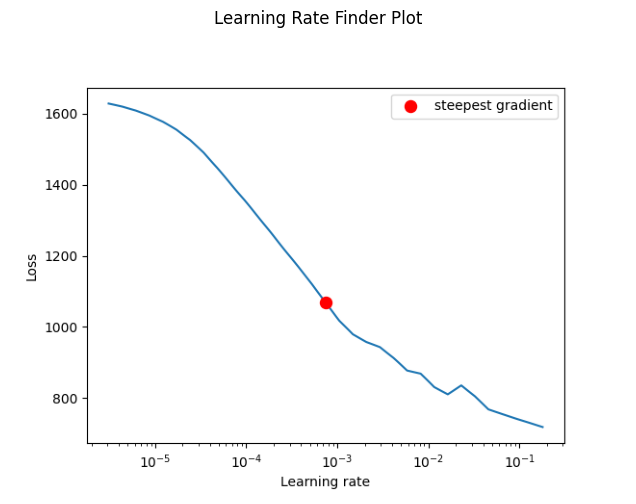

In [26]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [27]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.73 seconds
Best model found at epoch 31/100
Best Train Loss: 21.3712, Best Val Loss: 14.9745
Best Train MSE: 21.4460, Best Val MSE: 15.7031
Best Train RMSE: 4.6310, Best Val RMSE: 3.9627
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_blur_Model2/lr_finder_plot.png. Skipping LR finder process.


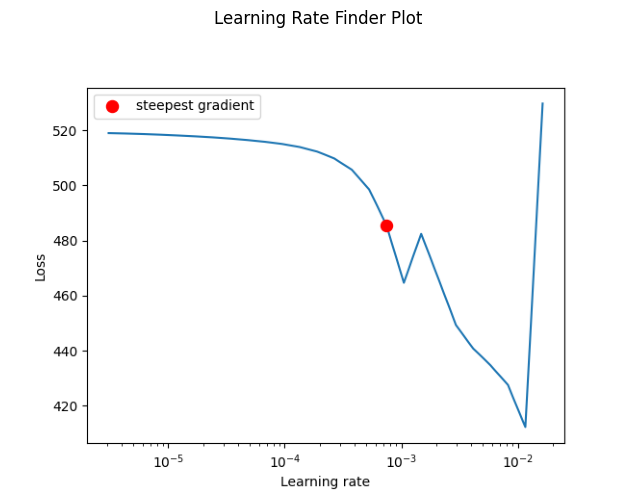

In [28]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [29]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 6.00 seconds
Best model found at epoch 29/100
Best Train Loss: 19.8397, Best Val Loss: 15.4974
Best Train MSE: 19.8259, Best Val MSE: 15.9374
Best Train RMSE: 4.4526, Best Val RMSE: 3.9922
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_blur_Model3/lr_finder_plot.png. Skipping LR finder process.


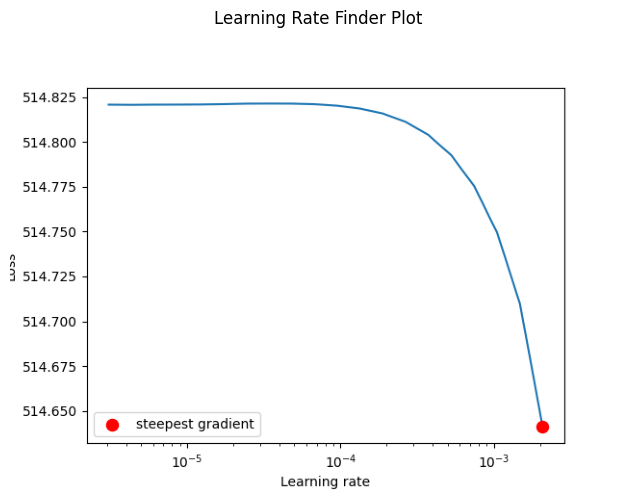

In [30]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [31]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 18.24 seconds
Best model found at epoch 25/100
Best Train Loss: 62.0329, Best Val Loss: 13.8703
Best Train MSE: 63.4505, Best Val MSE: 13.6752
Best Train RMSE: 7.9656, Best Val RMSE: 3.6980
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_Model3/best_model.pth


In [32]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 15.191420261676495, 'train_mse': 15.449475288391113, 'train_mae': 2.594167470932007, 'train_rmse': 3.9305820546569326, 'train_r2': 0.8163713216781616, 'val_loss': 14.974515914916992, 'val_mse': 15.703064918518066, 'val_mae': 2.787686586380005, 'val_rmse': 3.9627092901849443, 'val_r2': 0.7406419515609741, 'test_loss': 22.596346378326416, 'test_mse': 26.245878219604492, 'test_mae': 3.0928263664245605, 'test_rmse': 5.123073122609562, 'test_r2': 0.7527759075164795, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.733845472335815, 'average_epoch_time': 0.04733593702316284}
Model 2 Metrics: {'train_loss': 15.40622168320876, 'train_mse': 15.698491096496582, 'train_mae': 2.6276395320892334, 'train_rmse': 3.962132140211452, 'train_r2': 0.8134115934371948, 'val_loss': 15.49742317199707, 'val_mse': 15.937382698059082, 'val_mae': 2.750091552734375, 'val_rmse': 3.9921651641758364, 'val_r2': 0.736771821975708, 'test_loss': 21.25188899040222, 'test_mse': 24.81758117675

In [33]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, option="maximum", random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [34]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO_blur_maximum/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO_blur_maximum/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO_blur_maximum/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model1/lr_finder_plot.png. Skipping LR finder process.


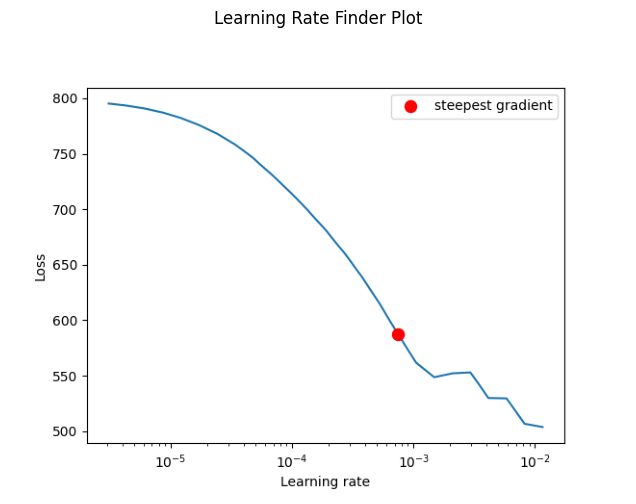

In [35]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [36]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.54 seconds
Best model found at epoch 24/100
Best Train Loss: 27.3120, Best Val Loss: 15.8330
Best Train MSE: 26.4656, Best Val MSE: 17.1600
Best Train RMSE: 5.1445, Best Val RMSE: 4.1425
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model2/lr_finder_plot.png. Skipping LR finder process.


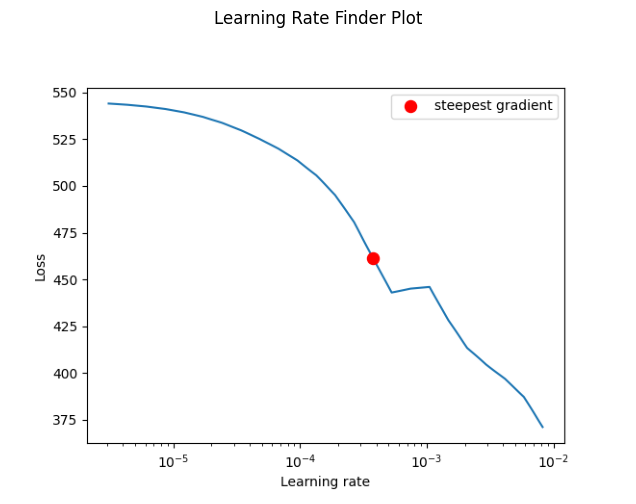

In [37]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [38]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.43 seconds
Best model found at epoch 73/100
Best Train Loss: 4.9199, Best Val Loss: 13.1018
Best Train MSE: 4.9121, Best Val MSE: 13.1106
Best Train RMSE: 2.2163, Best Val RMSE: 3.6209
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model3/lr_finder_plot.png. Skipping LR finder process.


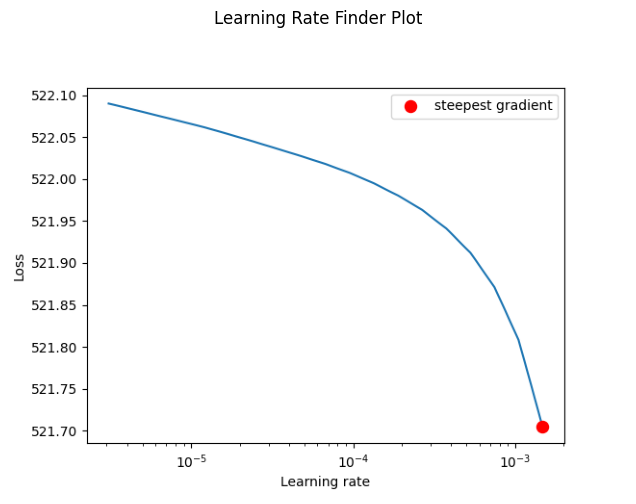

In [39]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [40]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-5, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.16 seconds
Best model found at epoch 43/100
Best Train Loss: 39.2729, Best Val Loss: 13.3681
Best Train MSE: 39.7594, Best Val MSE: 14.0866
Best Train RMSE: 6.3055, Best Val RMSE: 3.7532
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model3/best_model.pth


In [41]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 17.928282811091496, 'train_mse': 18.140947341918945, 'train_mae': 2.998587131500244, 'train_rmse': 4.259219100013398, 'train_r2': 0.784381091594696, 'val_loss': 15.83295726776123, 'val_mse': 17.1600399017334, 'val_mae': 3.2978150844573975, 'val_rmse': 4.142467851623401, 'val_r2': 0.7165780067443848, 'test_loss': 46.82537269592285, 'test_mse': 49.17559814453125, 'test_mae': 5.19188928604126, 'test_rmse': 7.012531507560679, 'test_r2': 0.5367884635925293, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.540834903717041, 'average_epoch_time': 0.04540575742721557}
Model 2 Metrics: {'train_loss': 4.6610795351175165, 'train_mse': 4.600469589233398, 'train_mae': 1.5913166999816895, 'train_rmse': 2.1448705297134834, 'train_r2': 0.9453199505805969, 'val_loss': 13.101819515228271, 'val_mse': 13.110636711120605, 'val_mae': 2.5868079662323, 'val_rmse': 3.620861321718992, 'val_r2': 0.7834595441818237, 'test_loss': 27.47992992401123, 'test_mse': 31.776752471923828, 'te

In [42]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [43]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_TINTO/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_Model1/lr_finder_plot.png. Skipping LR finder process.


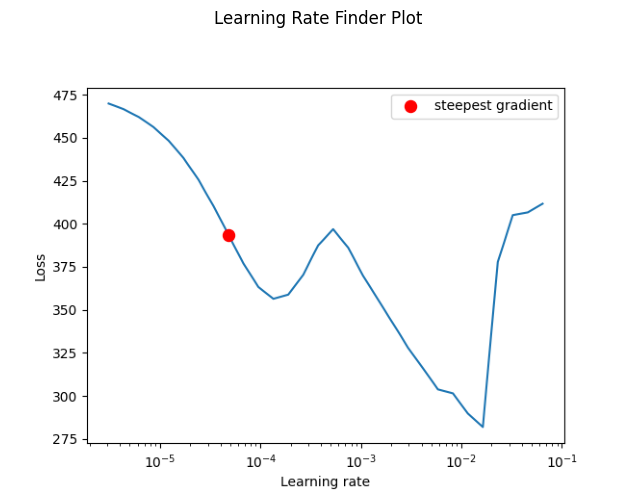

In [44]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [45]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.41 seconds
Best model found at epoch 32/100
Best Train Loss: 15.5076, Best Val Loss: 14.6338
Best Train MSE: 15.7798, Best Val MSE: 15.3438
Best Train RMSE: 3.9724, Best Val RMSE: 3.9171
Best model saved to models/Regression/boston/CNN+MLP/TINTO_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_Model2/lr_finder_plot.png. Skipping LR finder process.


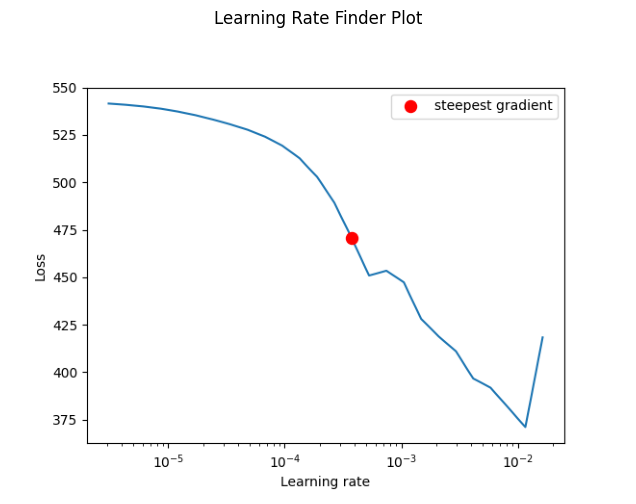

In [46]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [47]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.15 seconds
Best model found at epoch 26/100
Best Train Loss: 23.7567, Best Val Loss: 15.1997
Best Train MSE: 22.9039, Best Val MSE: 15.5963
Best Train RMSE: 4.7858, Best Val RMSE: 3.9492
Best model saved to models/Regression/boston/CNN+MLP/TINTO_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/TINTO_Model3/lr_finder_plot.png. Skipping LR finder process.


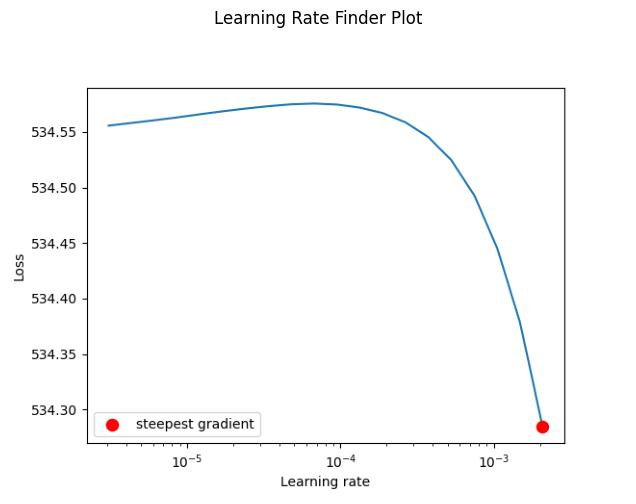

In [48]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [49]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.31 seconds
Best model found at epoch 61/100
Best Train Loss: 46.7406, Best Val Loss: 13.7672
Best Train MSE: 46.4136, Best Val MSE: 15.0035
Best Train RMSE: 6.8128, Best Val RMSE: 3.8734
Best model saved to models/Regression/boston/CNN+MLP/TINTO_Model3/best_model.pth


In [50]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 13.516112217536339, 'train_mse': 13.400470733642578, 'train_mae': 2.4267489910125732, 'train_rmse': 3.660665340295747, 'train_r2': 0.840725302696228, 'val_loss': 14.633806705474854, 'val_mse': 15.34380054473877, 'val_mae': 2.9040822982788086, 'val_rmse': 3.9171163557824995, 'val_r2': 0.7465757131576538, 'test_loss': 23.147483825683594, 'test_mse': 26.080184936523438, 'test_mae': 3.287065029144287, 'test_rmse': 5.106876240572453, 'test_r2': 0.7543366551399231, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.413593769073486, 'average_epoch_time': 0.04413321018218994}
Model 2 Metrics: {'train_loss': 13.27512711745042, 'train_mse': 12.81385326385498, 'train_mae': 2.383769989013672, 'train_rmse': 3.579644292922829, 'train_r2': 0.8476976752281189, 'val_loss': 15.199681758880615, 'val_mse': 15.5962553024292, 'val_mae': 2.7449541091918945, 'val_rmse': 3.949209452843594, 'val_r2': 0.7424060106277466, 'test_loss': 51.879639625549316, 'test_mse': 58.39736175537109

### EXPERIMENT 2: IGTD

In [51]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [52]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [53]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 4, 4)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_4x4_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png. Skipping LR finder process.


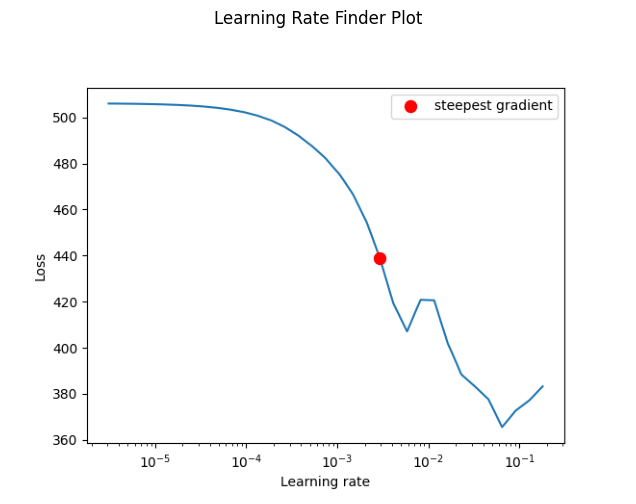

In [54]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [55]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=5e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.36 seconds
Best model found at epoch 11/100
Best Train Loss: 23.5795, Best Val Loss: 19.1811
Best Train MSE: 23.9822, Best Val MSE: 18.8956
Best Train RMSE: 4.8972, Best Val RMSE: 4.3469
Best model saved to models/Regression/boston/CNN+MLP/IGTD_4x4_fEuclidean_iEuclidean_abs_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_4x4_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png. Skipping LR finder process.


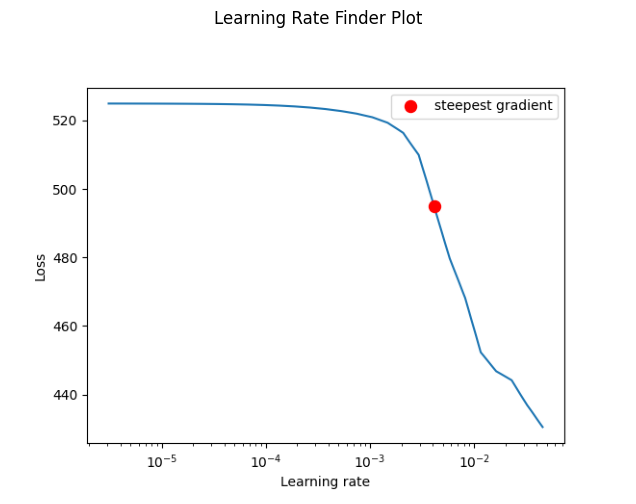

In [56]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [57]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=4e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.01 seconds
Best model found at epoch 11/100
Best Train Loss: 37.9473, Best Val Loss: 18.8119
Best Train MSE: 38.6488, Best Val MSE: 20.2111
Best Train RMSE: 6.2168, Best Val RMSE: 4.4957
Best model saved to models/Regression/boston/CNN+MLP/IGTD_4x4_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [58]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [59]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-5, max_lr=4e-4)  # Train and evaluate Model3

Error creating or testing Model3:
Model IGTD_4x4_fEuclidean_iEuclidean_abs_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [60]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 20.96764036325308, 'train_mse': 20.161449432373047, 'train_mae': 2.9923150539398193, 'train_rmse': 4.490150268351054, 'train_r2': 0.760365903377533, 'val_loss': 19.18105983734131, 'val_mse': 18.895553588867188, 'val_mae': 3.2456936836242676, 'val_rmse': 4.3469016079119145, 'val_r2': 0.6879135370254517, 'test_loss': 108.53641891479492, 'test_mse': 105.67281341552734, 'test_mae': 6.508141040802002, 'test_rmse': 10.279728275374177, 'test_r2': 0.004610657691955566, 'min_lr': 0.0001, 'max_lr': 0.05, 'total_time': 4.361289978027344, 'average_epoch_time': 0.043610877990722656}
Model 2 Metrics: {'train_loss': 20.36081702892597, 'train_mse': 20.409503936767578, 'train_mae': 3.1827733516693115, 'train_rmse': 4.5176878972288, 'train_r2': 0.757417619228363, 'val_loss': 18.811938285827637, 'val_mse': 20.211105346679688, 'val_mae': 3.5368340015411377, 'val_rmse': 4.49567629469468, 'val_r2': 0.6661853790283203, 'test_loss': 69.69831085205078, 'test_mse': 75.16136932373

In [61]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=2, random_seed=SEED)
name = f"IGTD_{image_size*2}x{image_size*2}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [62]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_8x8_fEuclidean_iEuclidean_abs/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_8x8_fEuclidean_iEuclidean_abs/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_8x8_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 8, 8)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_8x8_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png. Skipping LR finder process.


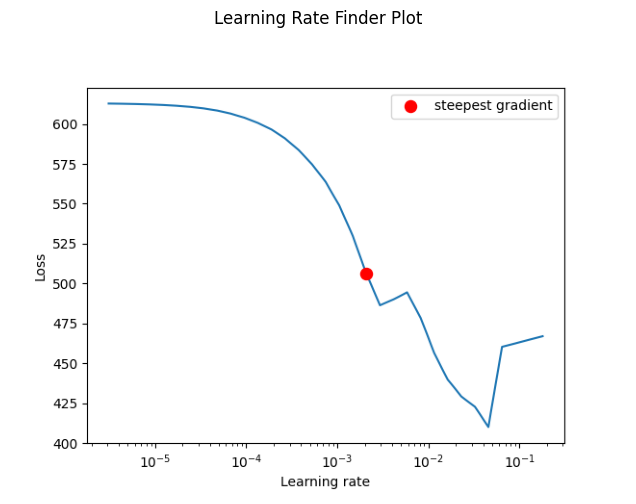

In [63]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [64]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.35 seconds
Best model found at epoch 23/100
Best Train Loss: 20.6659, Best Val Loss: 19.1562
Best Train MSE: 20.7600, Best Val MSE: 18.9704
Best Train RMSE: 4.5563, Best Val RMSE: 4.3555
Best model saved to models/Regression/boston/CNN+MLP/IGTD_8x8_fEuclidean_iEuclidean_abs_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_8x8_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png. Skipping LR finder process.


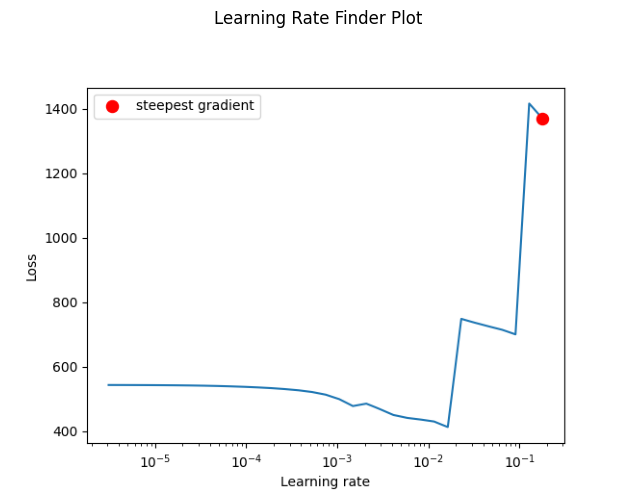

In [65]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [66]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.18 seconds
Best model found at epoch 22/100
Best Train Loss: 33.4025, Best Val Loss: 19.9386
Best Train MSE: 33.4488, Best Val MSE: 20.8436
Best Train RMSE: 5.7835, Best Val RMSE: 4.5655
Best model saved to models/Regression/boston/CNN+MLP/IGTD_8x8_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [67]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [68]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=6e-2)  # Train and evaluate Model3

Error creating or testing Model3:
Model IGTD_8x8_fEuclidean_iEuclidean_abs_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [69]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 19.440249076256386, 'train_mse': 19.83728790283203, 'train_mae': 2.959737539291382, 'train_rmse': 4.453907037964761, 'train_r2': 0.764218807220459, 'val_loss': 19.1561861038208, 'val_mse': 18.97038459777832, 'val_mae': 2.912283182144165, 'val_rmse': 4.355500499113543, 'val_r2': 0.6866775751113892, 'test_loss': 42.23381042480469, 'test_mse': 44.885101318359375, 'test_mae': 4.6731181144714355, 'test_rmse': 6.699634416769275, 'test_r2': 0.5772029757499695, 'min_lr': 0.0001, 'max_lr': 0.03, 'total_time': 4.349700927734375, 'average_epoch_time': 0.04349507093429565}
Model 2 Metrics: {'train_loss': 23.162273260263298, 'train_mse': 23.328901290893555, 'train_mae': 4.002050876617432, 'train_rmse': 4.830000133632871, 'train_r2': 0.722718358039856, 'val_loss': 19.938568115234375, 'val_mse': 20.843645095825195, 'val_mae': 3.686185598373413, 'val_rmse': 4.565484103118222, 'val_r2': 0.6557380557060242, 'test_loss': 45.62172317504883, 'test_mse': 50.789310455322266, '

In [70]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=4, random_seed=SEED)
name = f"IGTD_{image_size*4}x{image_size*4}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [71]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_16x16_fEuclidean_iEuclidean_abs/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_16x16_fEuclidean_iEuclidean_abs/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_IGTD_16x16_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 16, 16)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_16x16_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png. Skipping LR finder process.


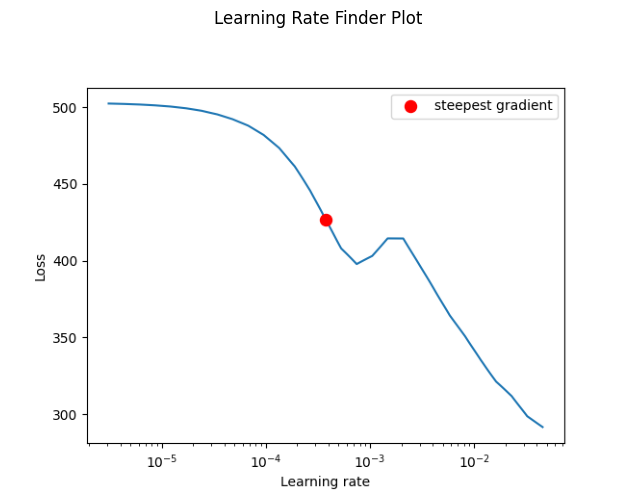

In [72]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [73]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.61 seconds
Best model found at epoch 24/100
Best Train Loss: 53.1471, Best Val Loss: 17.7515
Best Train MSE: 51.8675, Best Val MSE: 18.6152
Best Train RMSE: 7.2019, Best Val RMSE: 4.3145
Best model saved to models/Regression/boston/CNN+MLP/IGTD_16x16_fEuclidean_iEuclidean_abs_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_16x16_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png. Skipping LR finder process.


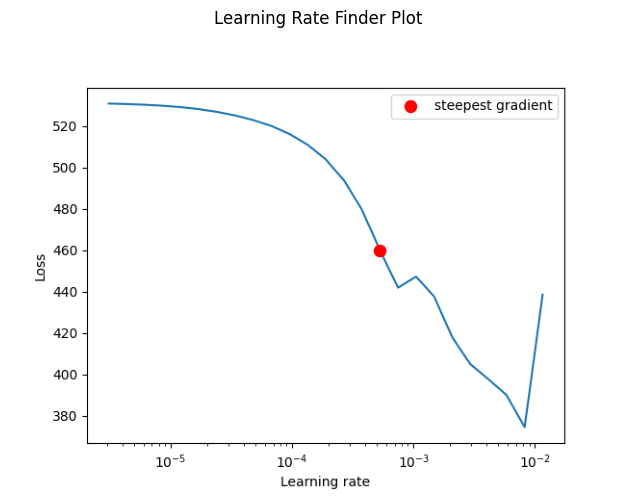

In [74]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [75]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-5, max_lr=7e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.24 seconds
Best model found at epoch 87/100
Best Train Loss: 8.9242, Best Val Loss: 14.8311
Best Train MSE: 9.0923, Best Val MSE: 15.2403
Best Train RMSE: 3.0153, Best Val RMSE: 3.9039
Best model saved to models/Regression/boston/CNN+MLP/IGTD_16x16_fEuclidean_iEuclidean_abs_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/IGTD_16x16_fEuclidean_iEuclidean_abs_Model3/lr_finder_plot.png. Skipping LR finder process.


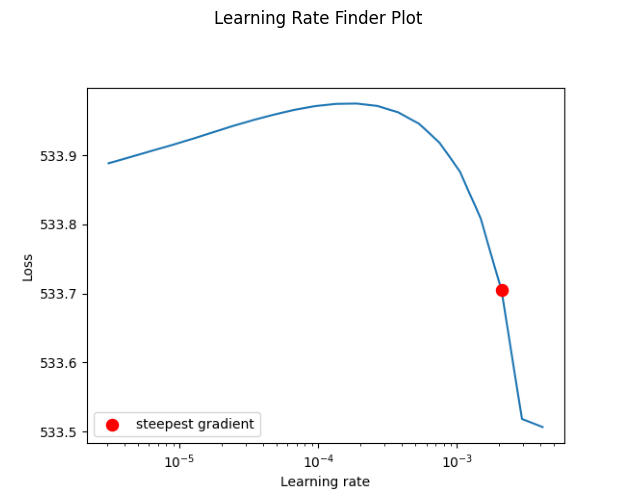

In [76]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [77]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=3e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 16.52 seconds
Best model found at epoch 48/100
Best Train Loss: 57.4335, Best Val Loss: 18.1752
Best Train MSE: 57.4859, Best Val MSE: 18.3485
Best Train RMSE: 7.5819, Best Val RMSE: 4.2835
Best model saved to models/Regression/boston/CNN+MLP/IGTD_16x16_fEuclidean_iEuclidean_abs_Model3/best_model.pth


In [78]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 19.23592626131498, 'train_mse': 19.246992111206055, 'train_mae': 3.23191237449646, 'train_rmse': 4.387139399563918, 'train_r2': 0.7712349891662598, 'val_loss': 17.751525402069092, 'val_mse': 18.615190505981445, 'val_mae': 3.196855068206787, 'val_rmse': 4.314532478262442, 'val_r2': 0.6925441026687622, 'test_loss': 67.77692031860352, 'test_mse': 72.26936340332031, 'test_mae': 6.540666580200195, 'test_rmse': 8.50113894741877, 'test_r2': 0.3192558288574219, 'min_lr': 1e-05, 'max_lr': 0.03, 'total_time': 4.609610080718994, 'average_epoch_time': 0.04609427452087402}
Model 2 Metrics: {'train_loss': 8.814329880934496, 'train_mse': 8.995789527893066, 'train_mae': 2.064117193222046, 'train_rmse': 2.9992981725552172, 'train_r2': 0.8930782675743103, 'val_loss': 14.831080913543701, 'val_mse': 15.240263938903809, 'val_mae': 2.892091751098633, 'val_rmse': 3.903878064041423, 'val_r2': 0.7482857704162598, 'test_loss': 18.79146099090576, 'test_mse': 21.371688842773438, 't

### EXPERIMENT 3: REFINED

In [79]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, random_seed=SEED)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [80]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED/test/regression.csv
Images shape:  (3, 4, 4)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_Model1/lr_finder_plot.png. Skipping LR finder process.


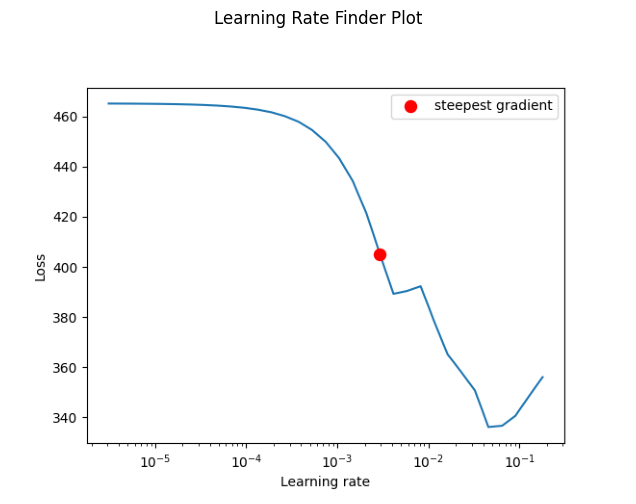

In [81]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [82]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-4, max_lr=4e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.43 seconds
Best model found at epoch 99/100
Best Train Loss: 9.6082, Best Val Loss: 14.3903
Best Train MSE: 9.7274, Best Val MSE: 14.7328
Best Train RMSE: 3.1189, Best Val RMSE: 3.8383
Best model saved to models/Regression/boston/CNN+MLP/REFINED_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_Model2/lr_finder_plot.png. Skipping LR finder process.


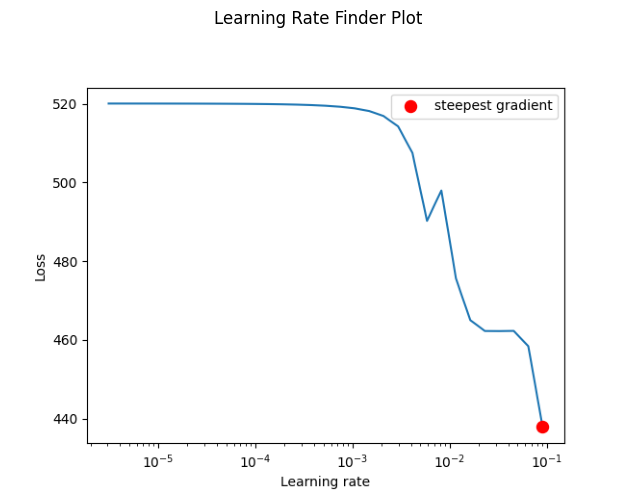

In [83]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [84]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=8e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.00 seconds
Best model found at epoch 65/100
Best Train Loss: 16.5546, Best Val Loss: 14.3247
Best Train MSE: 16.4703, Best Val MSE: 14.6660
Best Train RMSE: 4.0584, Best Val RMSE: 3.8296
Best model saved to models/Regression/boston/CNN+MLP/REFINED_Model2/best_model.pth


In [85]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [86]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-5, max_lr=6e-4)  # Train and evaluate Model3

Error creating or testing Model3:
Model REFINED_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [87]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 9.580241460066576, 'train_mse': 9.717382431030273, 'train_mae': 2.155996084213257, 'train_rmse': 3.117271632538665, 'train_r2': 0.884501576423645, 'val_loss': 14.390281677246094, 'val_mse': 14.732797622680664, 'val_mae': 2.916656255722046, 'val_rmse': 3.8383326618052096, 'val_r2': 0.7566672563552856, 'test_loss': 116.32882308959961, 'test_mse': 118.1215591430664, 'test_mae': 9.862228393554688, 'test_rmse': 10.868374264031692, 'test_r2': -0.11265087127685547, 'min_lr': 0.0002, 'max_lr': 0.04, 'total_time': 4.431766033172607, 'average_epoch_time': 0.044315927028656006}
Model 2 Metrics: {'train_loss': 14.940439040844257, 'train_mse': 15.12947940826416, 'train_mae': 2.680060863494873, 'train_rmse': 3.889663148431257, 'train_r2': 0.8201746940612793, 'val_loss': 14.324687480926514, 'val_mse': 14.666029930114746, 'val_mae': 2.865945339202881, 'val_rmse': 3.8296252989182564, 'val_r2': 0.7577700018882751, 'test_loss': 17.60838270187378, 'test_mse': 20.75888442993

In [88]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=2, random_seed=SEED)
name = f"REFINED_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [89]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED_zoom2/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED_zoom2/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED_zoom2/test/regression.csv
Images shape:  (3, 8, 8)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_zoom2_Model1/lr_finder_plot.png. Skipping LR finder process.


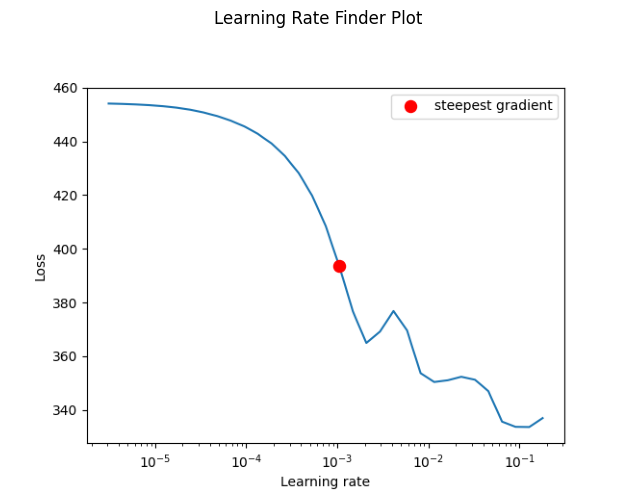

In [90]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [91]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=1e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.48 seconds
Best model found at epoch 13/100
Best Train Loss: 25.2330, Best Val Loss: 17.1774
Best Train MSE: 25.3636, Best Val MSE: 18.2096
Best Train RMSE: 5.0362, Best Val RMSE: 4.2673
Best model saved to models/Regression/boston/CNN+MLP/REFINED_zoom2_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_zoom2_Model2/lr_finder_plot.png. Skipping LR finder process.


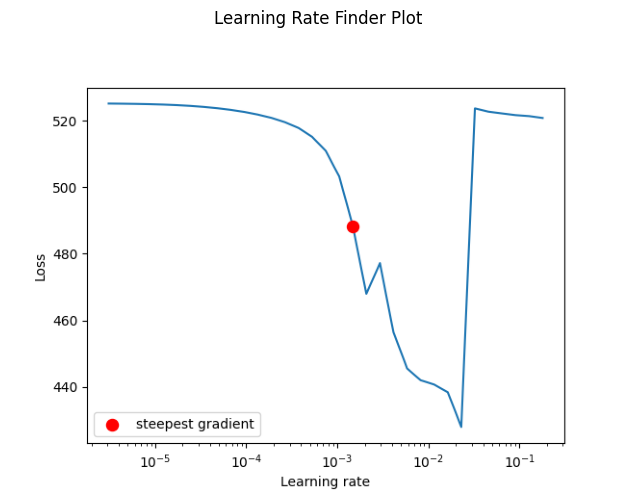

In [92]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [93]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.27 seconds
Best model found at epoch 27/100
Best Train Loss: 22.6432, Best Val Loss: 15.2931
Best Train MSE: 22.7019, Best Val MSE: 16.2173
Best Train RMSE: 4.7647, Best Val RMSE: 4.0271
Best model saved to models/Regression/boston/CNN+MLP/REFINED_zoom2_Model2/best_model.pth


In [94]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [95]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=9e-2)  # Train and evaluate Model3

Error creating or testing Model3:
Model REFINED_zoom2_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [96]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 15.398456206688515, 'train_mse': 15.490609169006348, 'train_mae': 2.792836904525757, 'train_rmse': 3.9358111195795904, 'train_r2': 0.8158823847770691, 'val_loss': 17.177438735961914, 'val_mse': 18.209646224975586, 'val_mae': 3.358654737472534, 'val_rmse': 4.267276206782915, 'val_r2': 0.6992422342300415, 'test_loss': 23.90157413482666, 'test_mse': 26.548171997070312, 'test_mae': 3.8897528648376465, 'test_rmse': 5.152491824066324, 'test_r2': 0.7499284148216248, 'min_lr': 0.0001, 'max_lr': 0.1, 'total_time': 4.479944467544556, 'average_epoch_time': 0.044797601699829104}
Model 2 Metrics: {'train_loss': 14.388450439159687, 'train_mse': 14.588058471679688, 'train_mae': 2.5754005908966064, 'train_rmse': 3.8194316948571925, 'train_r2': 0.8266099095344543, 'val_loss': 15.293071746826172, 'val_mse': 16.217321395874023, 'val_mae': 3.0250048637390137, 'val_rmse': 4.027073552329783, 'val_r2': 0.732148289680481, 'test_loss': 62.23315620422363, 'test_mse': 64.870857238

In [97]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=4, random_seed=SEED)
name = f"REFINED_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [98]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED_zoom4/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED_zoom4/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_REFINED_zoom4/test/regression.csv
Images shape:  (3, 16, 16)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_zoom4_Model1/lr_finder_plot.png. Skipping LR finder process.


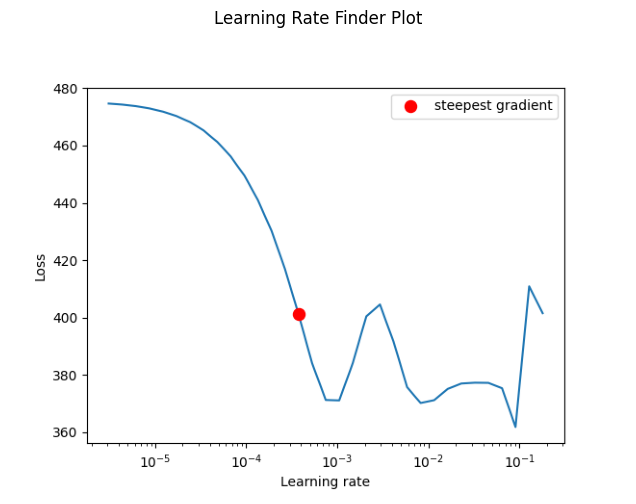

In [99]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [100]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.69 seconds
Best model found at epoch 93/100
Best Train Loss: 10.9776, Best Val Loss: 14.9211
Best Train MSE: 11.0118, Best Val MSE: 15.2423
Best Train RMSE: 3.3184, Best Val RMSE: 3.9041
Best model saved to models/Regression/boston/CNN+MLP/REFINED_zoom4_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_zoom4_Model2/lr_finder_plot.png. Skipping LR finder process.


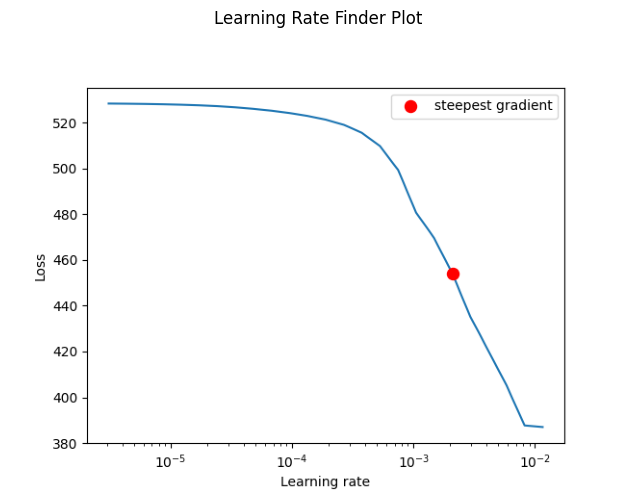

In [101]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [102]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.10 seconds
Best model found at epoch 96/100
Best Train Loss: 11.9962, Best Val Loss: 13.6663
Best Train MSE: 11.8853, Best Val MSE: 13.4694
Best Train RMSE: 3.4475, Best Val RMSE: 3.6701
Best model saved to models/Regression/boston/CNN+MLP/REFINED_zoom4_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/REFINED_zoom4_Model3/lr_finder_plot.png. Skipping LR finder process.


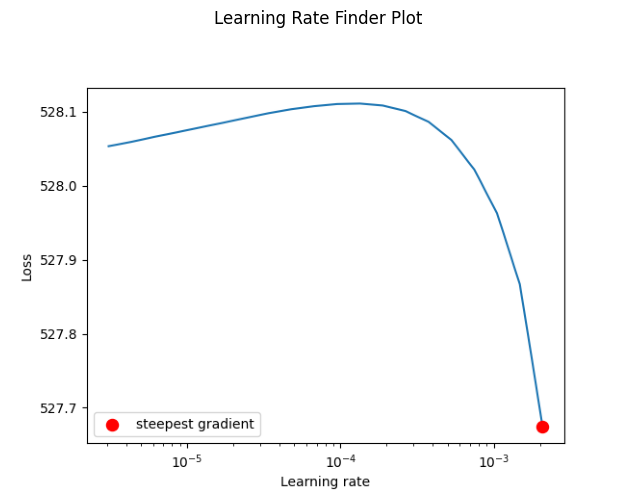

In [103]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [104]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=3e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 16.27 seconds
Best model found at epoch 50/100
Best Train Loss: 34.6320, Best Val Loss: 13.4916
Best Train MSE: 34.7030, Best Val MSE: 13.8202
Best Train RMSE: 5.8909, Best Val RMSE: 3.7176
Best model saved to models/Regression/boston/CNN+MLP/REFINED_zoom4_Model3/best_model.pth


In [105]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 10.854915398817797, 'train_mse': 10.904772758483887, 'train_mae': 2.2458250522613525, 'train_rmse': 3.3022375381677023, 'train_r2': 0.8703885078430176, 'val_loss': 14.921136379241943, 'val_mse': 15.242270469665527, 'val_mae': 3.0208122730255127, 'val_rmse': 3.9041350475701435, 'val_r2': 0.7482526302337646, 'test_loss': 64.85531997680664, 'test_mse': 66.97517395019531, 'test_mae': 6.877830505371094, 'test_rmse': 8.183836139011785, 'test_r2': 0.3691246509552002, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.693915843963623, 'average_epoch_time': 0.04693711280822754}
Model 2 Metrics: {'train_loss': 12.33115236575787, 'train_mse': 11.855667114257812, 'train_mae': 2.30287766456604, 'train_rmse': 3.4432059354993294, 'train_r2': 0.8590863943099976, 'val_loss': 13.666345596313477, 'val_mse': 13.469369888305664, 'val_mae': 2.76419997215271, 'val_rmse': 3.6700640169220025, 'val_r2': 0.777534544467926, 'test_loss': 36.45075702667236, 'test_mse': 39.4291915893554

### EXPERIMENT 4: BAR GRAPH

In [106]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem = problem_type)
name = f"BarGraph"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [107]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_Model1/lr_finder_plot.png. Skipping LR finder process.


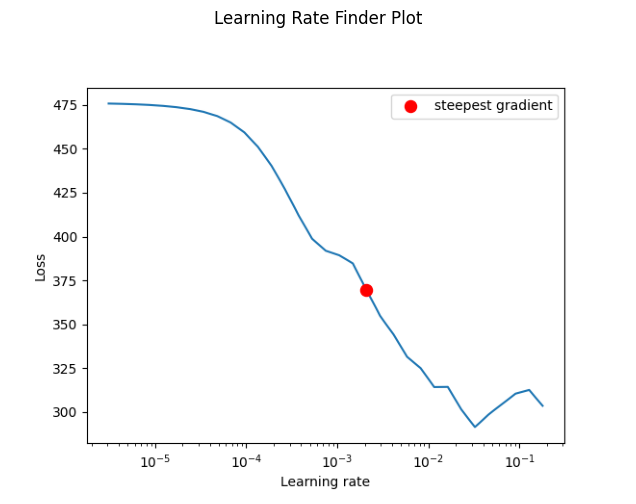

In [108]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [109]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-5, max_lr=2e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.54 seconds
Best model found at epoch 16/100
Best Train Loss: 17.1342, Best Val Loss: 17.5168
Best Train MSE: 16.0415, Best Val MSE: 17.9169
Best Train RMSE: 4.0052, Best Val RMSE: 4.2328
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_Model2/lr_finder_plot.png. Skipping LR finder process.


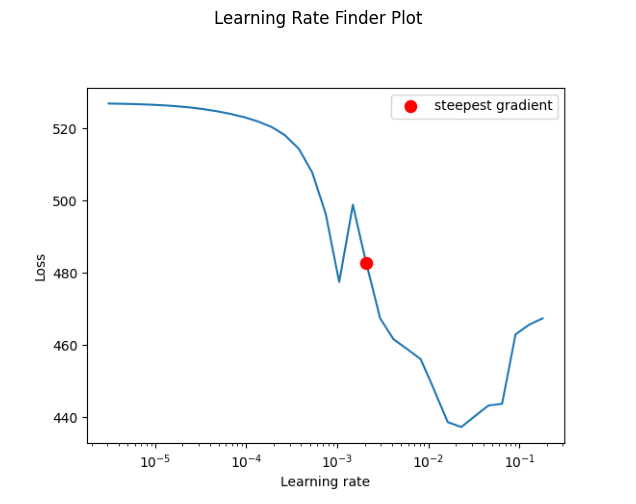

In [110]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [111]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=2e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.10 seconds
Best model found at epoch 35/100
Best Train Loss: 16.7007, Best Val Loss: 12.4958
Best Train MSE: 17.0711, Best Val MSE: 13.6236
Best Train RMSE: 4.1317, Best Val RMSE: 3.6910
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_Model2/best_model.pth


In [112]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [113]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=6e-2)  # Train and evaluate Model3

Error creating or testing Model3:
Model BarGraph_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [114]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 11.87949719795814, 'train_mse': 11.850269317626953, 'train_mae': 2.4923582077026367, 'train_rmse': 3.4424220132963, 'train_r2': 0.8591505885124207, 'val_loss': 17.516818523406982, 'val_mse': 17.91686248779297, 'val_mae': 2.986910104751587, 'val_rmse': 4.23283149768485, 'val_r2': 0.704077959060669, 'test_loss': 26.919728755950928, 'test_mse': 29.747983932495117, 'test_mae': 3.595627546310425, 'test_rmse': 5.45417124158154, 'test_r2': 0.7197876572608948, 'min_lr': 5e-05, 'max_lr': 0.02, 'total_time': 4.541846513748169, 'average_epoch_time': 0.045416669845581056}
Model 2 Metrics: {'train_loss': 7.699695623837984, 'train_mse': 7.774073123931885, 'train_mae': 1.9736202955245972, 'train_rmse': 2.788202489765025, 'train_r2': 0.9075992703437805, 'val_loss': 12.495832443237305, 'val_mse': 13.62364387512207, 'val_mae': 2.9046733379364014, 'val_rmse': 3.691022063754438, 'val_r2': 0.7749865055084229, 'test_loss': 21.70412540435791, 'test_mse': 23.77490234375, 'test_

In [115]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=2)
name = f"BarGraph_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [116]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom2/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom2/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom2/test/regression.csv
Images shape:  (3, 26, 26)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_zoom2_Model1/lr_finder_plot.png. Skipping LR finder process.


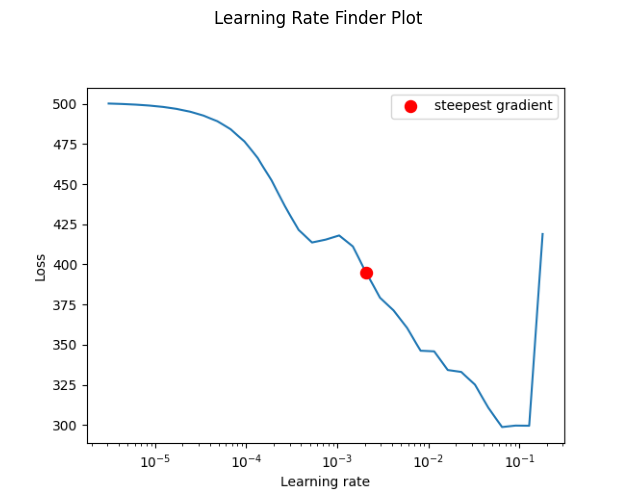

In [117]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [118]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=6e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.65 seconds
Best model found at epoch 7/100
Best Train Loss: 20.0756, Best Val Loss: 23.1881
Best Train MSE: 20.3528, Best Val MSE: 23.2609
Best Train RMSE: 4.5114, Best Val RMSE: 4.8230
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_zoom2_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_zoom2_Model2/lr_finder_plot.png. Skipping LR finder process.


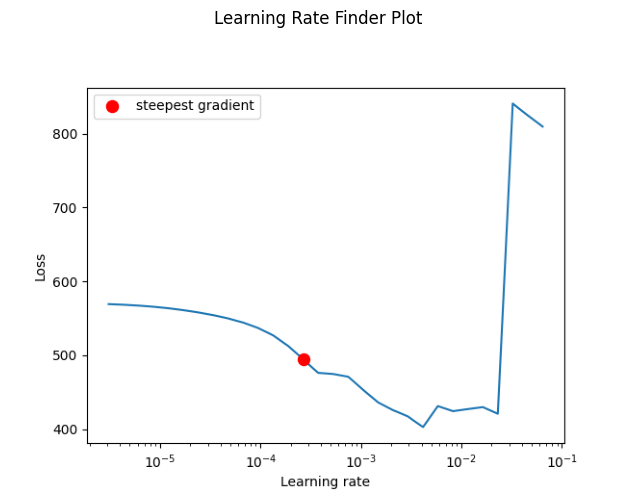

In [119]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [120]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=3e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.39 seconds
Best model found at epoch 9/100
Best Train Loss: 21.0405, Best Val Loss: 17.1123
Best Train MSE: 21.0749, Best Val MSE: 16.9373
Best Train RMSE: 4.5907, Best Val RMSE: 4.1155
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_zoom2_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_zoom2_Model3/lr_finder_plot.png. Skipping LR finder process.


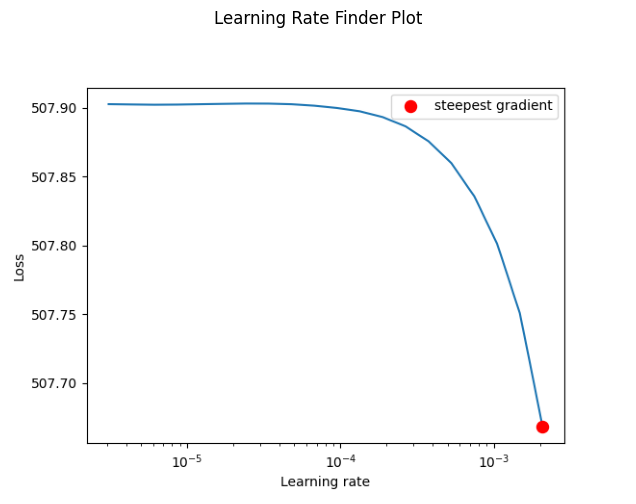

In [121]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [122]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 18.40 seconds
Best model found at epoch 60/100
Best Train Loss: 48.8656, Best Val Loss: 18.9150
Best Train MSE: 49.5466, Best Val MSE: 19.2326
Best Train RMSE: 7.0389, Best Val RMSE: 4.3855
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_zoom2_Model3/best_model.pth


In [123]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 17.735321338360126, 'train_mse': 18.017934799194336, 'train_mae': 3.009181499481201, 'train_rmse': 4.244753797241288, 'train_r2': 0.7858432531356812, 'val_loss': 23.18809223175049, 'val_mse': 23.26094627380371, 'val_mae': 3.641289234161377, 'val_rmse': 4.822960322644559, 'val_r2': 0.6158129572868347, 'test_loss': 35.33981132507324, 'test_mse': 39.5155143737793, 'test_mae': 3.925065040588379, 'test_rmse': 6.286136681124528, 'test_r2': 0.6277819871902466, 'min_lr': 1e-05, 'max_lr': 0.06, 'total_time': 4.648236513137817, 'average_epoch_time': 0.04647974252700806}
Model 2 Metrics: {'train_loss': 17.7186488371629, 'train_mse': 17.955535888671875, 'train_mae': 2.8768932819366455, 'train_rmse': 4.237397301253669, 'train_r2': 0.7865849137306213, 'val_loss': 17.11230182647705, 'val_mse': 16.93733787536621, 'val_mae': 3.2654545307159424, 'val_rmse': 4.11549971150117, 'val_r2': 0.7202562093734741, 'test_loss': 53.71224594116211, 'test_mse': 58.3686408996582, 'test_

In [124]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=4)
name = f"BarGraph_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [125]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom4/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom4/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom4/test/regression.csv
Images shape:  (3, 52, 52)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_zoom4_Model1/lr_finder_plot.png. Skipping LR finder process.


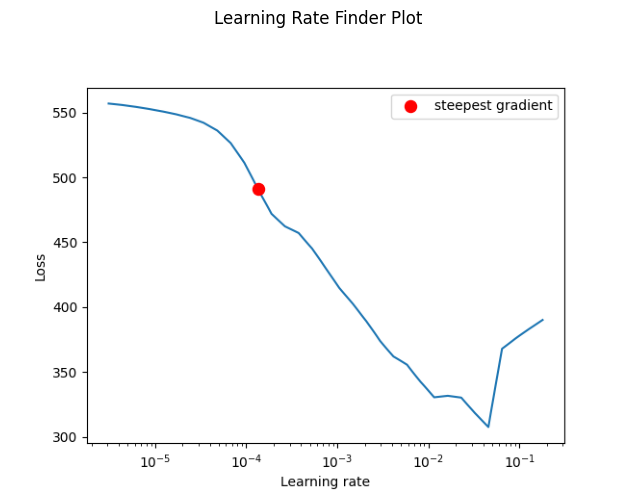

In [126]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [127]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 5.14 seconds
Best model found at epoch 9/100
Best Train Loss: 16.3727, Best Val Loss: 25.6764
Best Train MSE: 16.4272, Best Val MSE: 26.2944
Best Train RMSE: 4.0530, Best Val RMSE: 5.1278
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_zoom4_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_zoom4_Model2/lr_finder_plot.png. Skipping LR finder process.


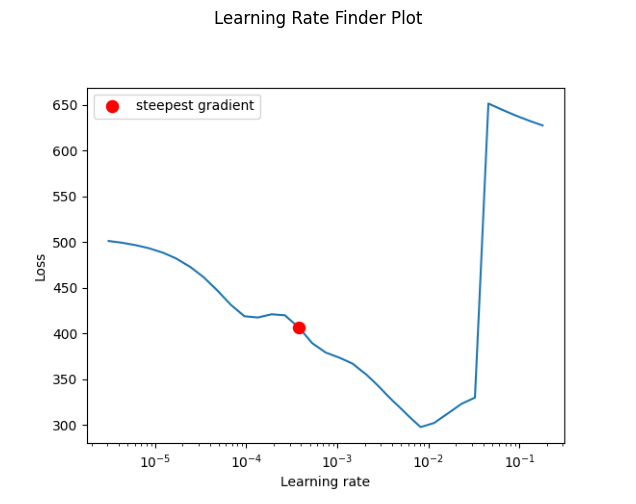

In [128]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [129]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=7e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.94 seconds
Best model found at epoch 6/100
Best Train Loss: 20.0161, Best Val Loss: 20.2231
Best Train MSE: 19.7423, Best Val MSE: 21.0749
Best Train RMSE: 4.4432, Best Val RMSE: 4.5907
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_zoom4_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BarGraph_zoom4_Model3/lr_finder_plot.png. Skipping LR finder process.


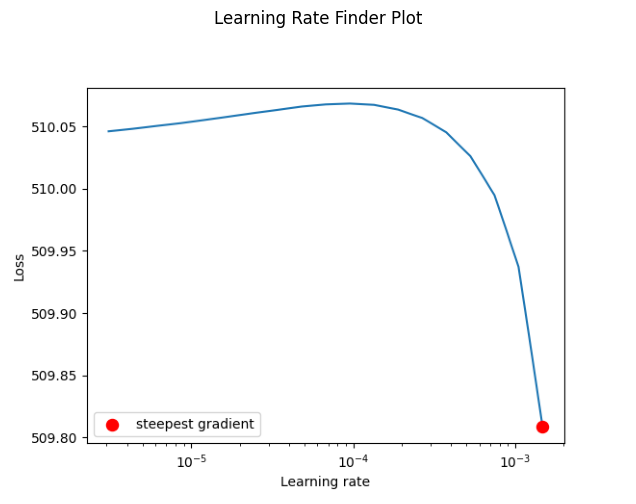

In [130]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [131]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.84 seconds
Best model found at epoch 51/100
Best Train Loss: 73.8263, Best Val Loss: 19.3589
Best Train MSE: 73.8155, Best Val MSE: 19.6800
Best Train RMSE: 8.5916, Best Val RMSE: 4.4362
Best model saved to models/Regression/boston/CNN+MLP/BarGraph_zoom4_Model3/best_model.pth


In [132]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 14.934848015124981, 'train_mse': 14.903118133544922, 'train_mae': 3.0346388816833496, 'train_rmse': 3.8604556898823383, 'train_r2': 0.8228651881217957, 'val_loss': 25.676393508911133, 'val_mse': 26.29443359375, 'val_mae': 3.4878156185150146, 'val_rmse': 5.127809824257331, 'val_r2': 0.5657106637954712, 'test_loss': 36.617685317993164, 'test_mse': 39.231693267822266, 'test_mae': 4.242308139801025, 'test_rmse': 6.263520836384458, 'test_r2': 0.630455493927002, 'min_lr': 1e-05, 'max_lr': 0.03, 'total_time': 5.1368749141693115, 'average_epoch_time': 0.05136638164520264}
Model 2 Metrics: {'train_loss': 17.077932321108303, 'train_mse': 16.296245574951172, 'train_mae': 2.7662367820739746, 'train_rmse': 4.0368608565259185, 'train_r2': 0.806306779384613, 'val_loss': 20.223055839538574, 'val_mse': 21.074935913085938, 'val_mae': 3.2372422218322754, 'val_rmse': 4.590744592447497, 'val_r2': 0.6519179344177246, 'test_loss': 31.820852279663086, 'test_mse': 35.84529495239

### EXPERIMENT 5: DISTANCE MATRIX

In [133]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type)
name = f"DistanceMatrix"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [134]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_Model1/lr_finder_plot.png. Skipping LR finder process.


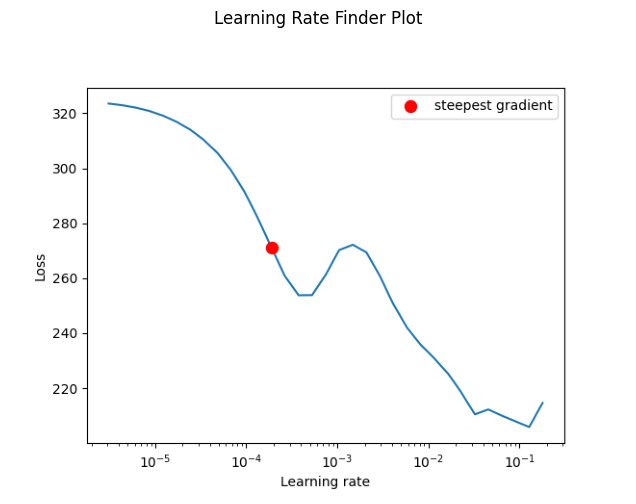

In [135]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [136]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.65 seconds
Best model found at epoch 39/100
Best Train Loss: 20.8417, Best Val Loss: 15.6811
Best Train MSE: 20.9463, Best Val MSE: 16.7665
Best Train RMSE: 4.5767, Best Val RMSE: 4.0947
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_Model2/lr_finder_plot.png. Skipping LR finder process.


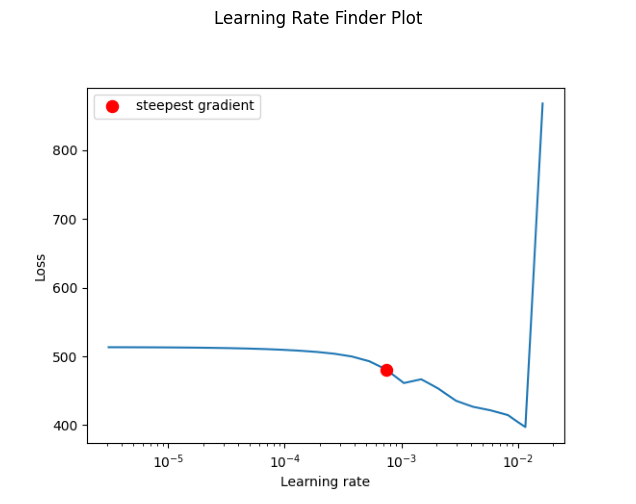

In [137]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [138]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.19 seconds
Best model found at epoch 86/100
Best Train Loss: 13.1318, Best Val Loss: 14.9181
Best Train MSE: 12.6216, Best Val MSE: 15.4330
Best Train RMSE: 3.5527, Best Val RMSE: 3.9285
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_Model2/best_model.pth


In [139]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [140]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model3

Error creating or testing Model3:
Model DistanceMatrix_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [141]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 17.48323532251211, 'train_mse': 17.365142822265625, 'train_mae': 2.8515892028808594, 'train_rmse': 4.167150443920357, 'train_r2': 0.7936021089553833, 'val_loss': 15.681100368499756, 'val_mse': 16.766494750976562, 'val_mae': 2.8534417152404785, 'val_rmse': 4.09469104463042, 'val_r2': 0.7230778932571411, 'test_loss': 22.76526665687561, 'test_mse': 26.693838119506836, 'test_mae': 3.052757501602173, 'test_rmse': 5.166607989726609, 'test_r2': 0.7485563158988953, 'min_lr': 1e-05, 'max_lr': 0.03, 'total_time': 4.649370908737183, 'average_epoch_time': 0.04649174690246582}
Model 2 Metrics: {'train_loss': 12.179747838240404, 'train_mse': 12.279403686523438, 'train_mae': 2.3264756202697754, 'train_rmse': 3.5041980090347975, 'train_r2': 0.8540500402450562, 'val_loss': 14.918078422546387, 'val_mse': 15.432958602905273, 'val_mae': 2.942741632461548, 'val_rmse': 3.928480444510991, 'val_r2': 0.745103120803833, 'test_loss': 16.184428930282593, 'test_mse': 18.689201354980

In [142]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=2)
name = f"DistanceMatrix_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [143]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2/test/regression.csv
Images shape:  (3, 26, 26)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_zoom2_Model1/lr_finder_plot.png. Skipping LR finder process.


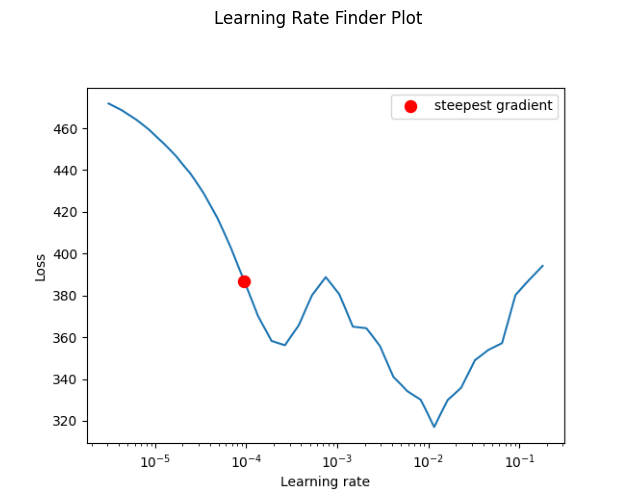

In [144]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [145]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.56 seconds
Best model found at epoch 77/100
Best Train Loss: 12.3789, Best Val Loss: 15.5879
Best Train MSE: 12.2764, Best Val MSE: 16.1065
Best Train RMSE: 3.5038, Best Val RMSE: 4.0133
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_zoom2_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_zoom2_Model2/lr_finder_plot.png. Skipping LR finder process.


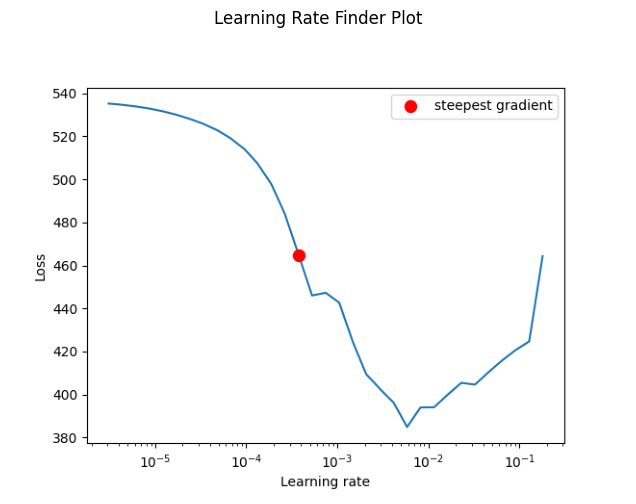

In [146]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [147]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=4e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.08 seconds
Best model found at epoch 88/100
Best Train Loss: 11.7938, Best Val Loss: 14.7589
Best Train MSE: 11.8136, Best Val MSE: 14.6648
Best Train RMSE: 3.4371, Best Val RMSE: 3.8295
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_zoom2_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_zoom2_Model3/lr_finder_plot.png. Skipping LR finder process.


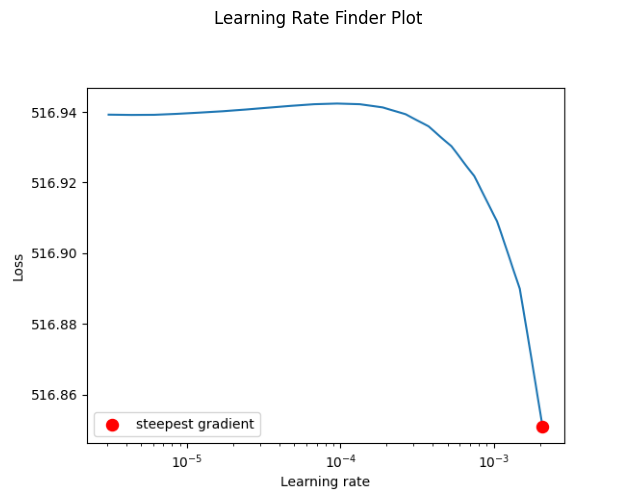

In [148]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [149]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.67 seconds
Best model found at epoch 42/100
Best Train Loss: 40.5101, Best Val Loss: 14.7241
Best Train MSE: 40.6104, Best Val MSE: 15.5306
Best Train RMSE: 6.3726, Best Val RMSE: 3.9409
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_zoom2_Model3/best_model.pth


In [150]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 12.261958819169264, 'train_mse': 11.754796028137207, 'train_mae': 2.27553391456604, 'train_rmse': 3.428526801431951, 'train_r2': 0.8602853417396545, 'val_loss': 15.587947845458984, 'val_mse': 16.106473922729492, 'val_mae': 2.9406278133392334, 'val_rmse': 4.013287171724632, 'val_r2': 0.7339791059494019, 'test_loss': 14.967718362808228, 'test_mse': 17.04789924621582, 'test_mae': 2.743227481842041, 'test_rmse': 4.128910176573937, 'test_r2': 0.8394166231155396, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.56003737449646, 'average_epoch_time': 0.04559816837310791}
Model 2 Metrics: {'train_loss': 11.313267084268423, 'train_mse': 11.52087688446045, 'train_mae': 2.3263070583343506, 'train_rmse': 3.394241724518224, 'train_r2': 0.8630656599998474, 'val_loss': 14.758875370025635, 'val_mse': 14.664763450622559, 'val_mae': 2.8549721240997314, 'val_rmse': 3.829459942423025, 'val_r2': 0.7577909231185913, 'test_loss': 16.23674726486206, 'test_mse': 18.55354881286621

In [151]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=4)
name = f"DistanceMatrix_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [152]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4/test/regression.csv
Images shape:  (3, 52, 52)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_zoom4_Model1/lr_finder_plot.png. Skipping LR finder process.


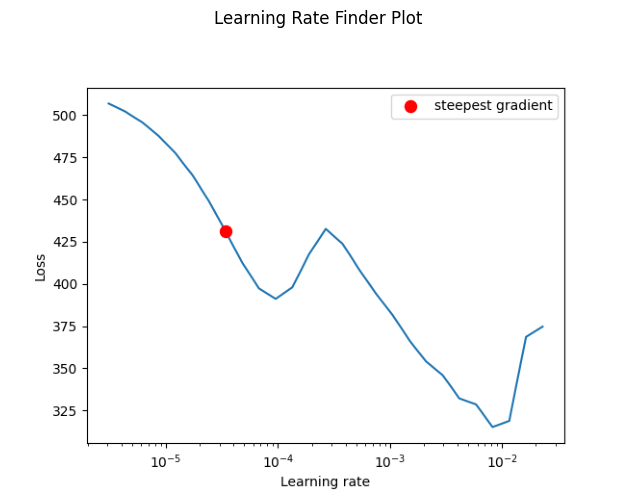

In [153]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [154]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=8e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.95 seconds
Best model found at epoch 68/100
Best Train Loss: 9.5912, Best Val Loss: 13.7134
Best Train MSE: 9.7364, Best Val MSE: 13.7946
Best Train RMSE: 3.1203, Best Val RMSE: 3.7141
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_zoom4_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_zoom4_Model2/lr_finder_plot.png. Skipping LR finder process.


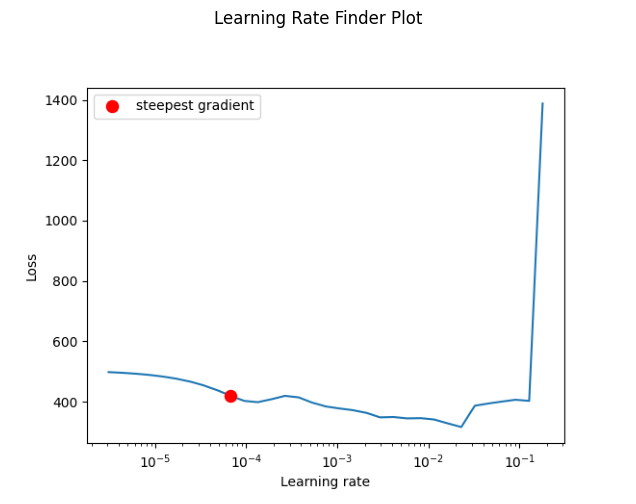

In [155]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [156]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.32 seconds
Best model found at epoch 88/100
Best Train Loss: 6.2752, Best Val Loss: 12.7828
Best Train MSE: 6.3547, Best Val MSE: 13.0648
Best Train RMSE: 2.5209, Best Val RMSE: 3.6145
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_zoom4_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/DistanceMatrix_zoom4_Model3/lr_finder_plot.png. Skipping LR finder process.


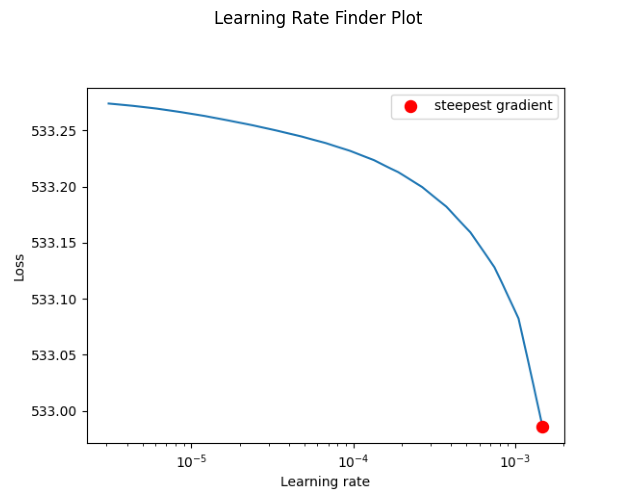

In [157]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [158]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-5, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 19.39 seconds
Best model found at epoch 31/100
Best Train Loss: 49.4998, Best Val Loss: 11.7907
Best Train MSE: 50.1715, Best Val MSE: 12.3158
Best Train RMSE: 7.0832, Best Val RMSE: 3.5094
Best model saved to models/Regression/boston/CNN+MLP/DistanceMatrix_zoom4_Model3/best_model.pth


In [159]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 9.50600684606112, 'train_mse': 9.588740348815918, 'train_mae': 2.06544828414917, 'train_rmse': 3.096569125470303, 'train_r2': 0.8860305547714233, 'val_loss': 13.713433265686035, 'val_mse': 13.794583320617676, 'val_mae': 2.7758212089538574, 'val_rmse': 3.71410599210869, 'val_r2': 0.7721631526947021, 'test_loss': 8.059922456741333, 'test_mse': 8.978580474853516, 'test_mae': 2.25701642036438, 'test_rmse': 2.9964279525550945, 'test_r2': 0.9154258966445923, 'min_lr': 1e-05, 'max_lr': 0.008, 'total_time': 4.953634977340698, 'average_epoch_time': 0.0495336651802063}
Model 2 Metrics: {'train_loss': 6.301198592552772, 'train_mse': 6.242400169372559, 'train_mae': 1.817868947982788, 'train_rmse': 2.498479571533968, 'train_r2': 0.9258043766021729, 'val_loss': 12.782832145690918, 'val_mse': 13.06481647491455, 'val_mae': 2.791186571121216, 'val_rmse': 3.6145285273344503, 'val_r2': 0.7842162847518921, 'test_loss': 9.372794389724731, 'test_mse': 10.115436553955078, 'tes

### EXPERIMENT 6: COMBINATION

In [160]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type)
name = f"Combination"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [161]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_Model1/lr_finder_plot.png. Skipping LR finder process.


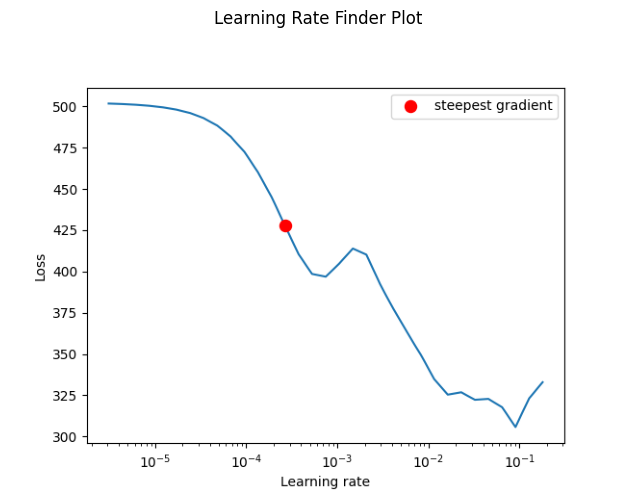

In [162]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [163]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=8e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.63 seconds
Best model found at epoch 7/100
Best Train Loss: 33.5596, Best Val Loss: 27.7228
Best Train MSE: 33.0546, Best Val MSE: 28.0593
Best Train RMSE: 5.7493, Best Val RMSE: 5.2971
Best model saved to models/Regression/boston/CNN+MLP/Combination_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_Model2/lr_finder_plot.png. Skipping LR finder process.


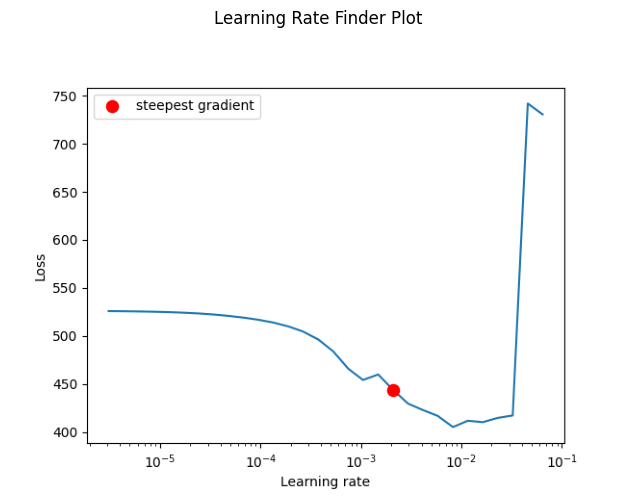

In [164]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [165]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.22 seconds
Best model found at epoch 80/100
Best Train Loss: 1.6355, Best Val Loss: 12.6290
Best Train MSE: 1.6635, Best Val MSE: 12.7172
Best Train RMSE: 1.2898, Best Val RMSE: 3.5661
Best model saved to models/Regression/boston/CNN+MLP/Combination_Model2/best_model.pth


In [166]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [167]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=1e-1)  # Train and evaluate Model3

Error creating or testing Model3:
Model Combination_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [168]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 23.576286682715782, 'train_mse': 23.660194396972656, 'train_mae': 3.235765218734741, 'train_rmse': 4.864174585371361, 'train_r2': 0.7187806367874146, 'val_loss': 27.72277069091797, 'val_mse': 28.059268951416016, 'val_mae': 3.7859323024749756, 'val_rmse': 5.2971000511049455, 'val_r2': 0.5365619659423828, 'test_loss': 36.16728210449219, 'test_mse': 39.88447952270508, 'test_mae': 4.085402488708496, 'test_rmse': 6.315416021348481, 'test_r2': 0.6243065595626831, 'min_lr': 1e-05, 'max_lr': 0.08, 'total_time': 4.628300189971924, 'average_epoch_time': 0.046281261444091795}
Model 2 Metrics: {'train_loss': 1.5184586002276494, 'train_mse': 1.5320093631744385, 'train_mae': 0.7912679314613342, 'train_rmse': 1.2377436581030978, 'train_r2': 0.9817909002304077, 'val_loss': 12.629031658172607, 'val_mse': 12.717238426208496, 'val_mae': 2.6856868267059326, 'val_rmse': 3.5661237255889615, 'val_r2': 0.7899570465087891, 'test_loss': 16.06689739227295, 'test_mse': 16.144081115

In [169]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=2)
name = f"Combination_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [170]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination_zoom2/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination_zoom2/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination_zoom2/test/regression.csv
Images shape:  (3, 26, 26)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_zoom2_Model1/lr_finder_plot.png. Skipping LR finder process.


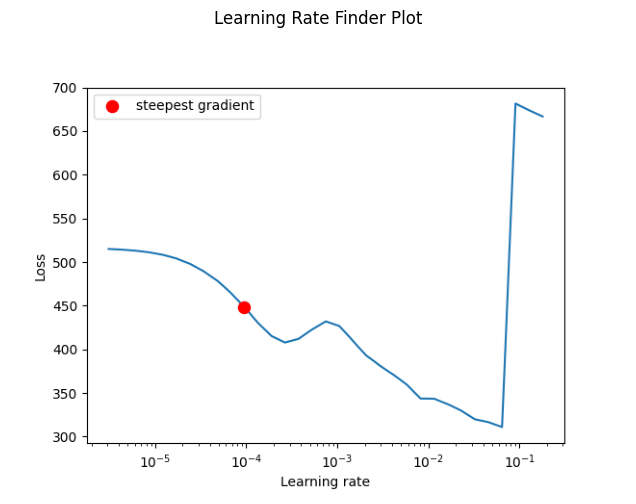

In [171]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [172]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=4e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 5.70 seconds
Best model found at epoch 22/100
Best Train Loss: 14.5242, Best Val Loss: 22.8490
Best Train MSE: 14.6141, Best Val MSE: 22.4765
Best Train RMSE: 3.8228, Best Val RMSE: 4.7409
Best model saved to models/Regression/boston/CNN+MLP/Combination_zoom2_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_zoom2_Model2/lr_finder_plot.png. Skipping LR finder process.


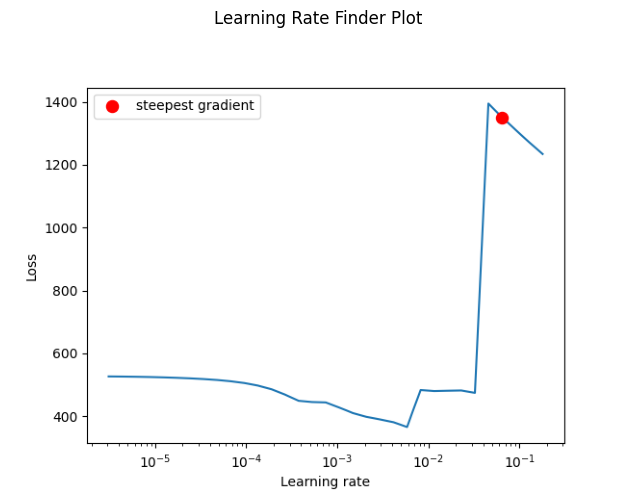

In [173]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [174]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=5e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.20 seconds
Best model found at epoch 8/100
Best Train Loss: 32.3533, Best Val Loss: 17.7731
Best Train MSE: 32.7609, Best Val MSE: 18.7904
Best Train RMSE: 5.7237, Best Val RMSE: 4.3348
Best model saved to models/Regression/boston/CNN+MLP/Combination_zoom2_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_zoom2_Model3/lr_finder_plot.png. Skipping LR finder process.


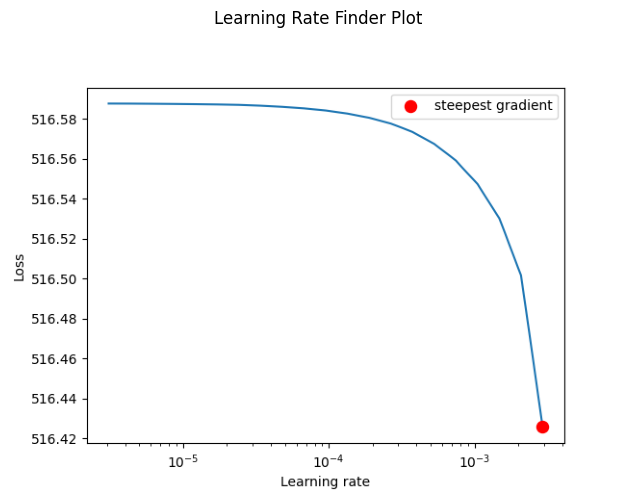

In [175]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [176]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=3e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.11 seconds
Best model found at epoch 31/100
Best Train Loss: 53.5023, Best Val Loss: 14.3849
Best Train MSE: 54.2570, Best Val MSE: 14.4862
Best Train RMSE: 7.3659, Best Val RMSE: 3.8061
Best model saved to models/Regression/boston/CNN+MLP/Combination_zoom2_Model3/best_model.pth


In [177]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 11.816990595597487, 'train_mse': 11.248805046081543, 'train_mae': 2.4486758708953857, 'train_rmse': 3.353923828306413, 'train_r2': 0.8662994503974915, 'val_loss': 22.849037170410156, 'val_mse': 22.476516723632812, 'val_mae': 3.5487372875213623, 'val_rmse': 4.740940489357867, 'val_r2': 0.6287689208984375, 'test_loss': 21.544914722442627, 'test_mse': 23.279916763305664, 'test_mae': 3.550154209136963, 'test_rmse': 4.824926607038252, 'test_r2': 0.7807139158248901, 'min_lr': 1e-05, 'max_lr': 0.04, 'total_time': 5.696481466293335, 'average_epoch_time': 0.05696252584457397}
Model 2 Metrics: {'train_loss': 22.051304670480583, 'train_mse': 21.970050811767578, 'train_mae': 3.1331214904785156, 'train_rmse': 4.687222078349561, 'train_r2': 0.738869309425354, 'val_loss': 17.773078441619873, 'val_mse': 18.79036521911621, 'val_mae': 3.472060441970825, 'val_rmse': 4.334785487093474, 'val_r2': 0.68965083360672, 'test_loss': 37.36246871948242, 'test_mse': 40.63172912597656

In [178]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)
name = f"Combination_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [179]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination_zoom4/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination_zoom4/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_Combination_zoom4/test/regression.csv
Images shape:  (3, 52, 52)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_zoom4_Model1/lr_finder_plot.png. Skipping LR finder process.


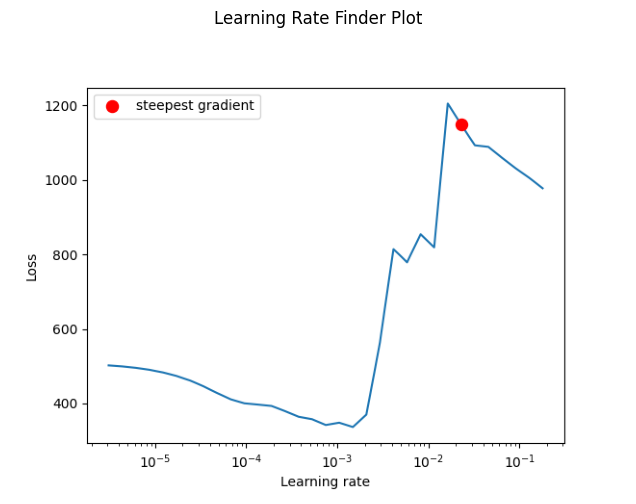

In [180]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [181]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.86 seconds
Best model found at epoch 9/100
Best Train Loss: 24.9848, Best Val Loss: 19.2401
Best Train MSE: 25.4482, Best Val MSE: 20.4713
Best Train RMSE: 5.0446, Best Val RMSE: 4.5245
Best model saved to models/Regression/boston/CNN+MLP/Combination_zoom4_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_zoom4_Model2/lr_finder_plot.png. Skipping LR finder process.


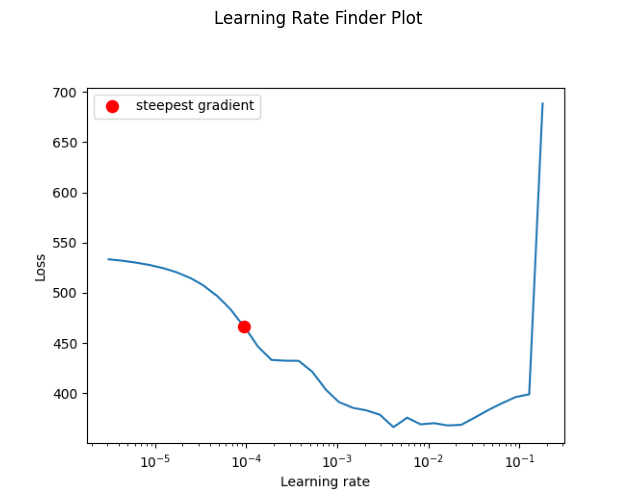

In [182]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [183]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=4e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.50 seconds
Best model found at epoch 8/100
Best Train Loss: 16.5941, Best Val Loss: 17.2389
Best Train MSE: 16.1585, Best Val MSE: 16.7060
Best Train RMSE: 4.0198, Best Val RMSE: 4.0873
Best model saved to models/Regression/boston/CNN+MLP/Combination_zoom4_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/Combination_zoom4_Model3/lr_finder_plot.png. Skipping LR finder process.


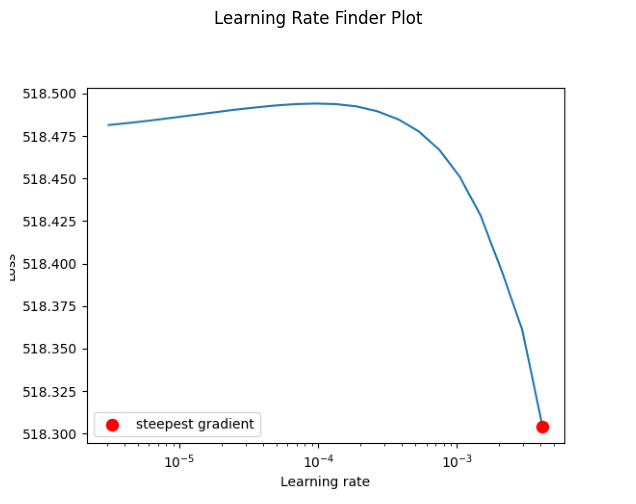

In [184]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [185]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=3e-4, max_lr=4e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 18.02 seconds
Best model found at epoch 48/100
Best Train Loss: 43.8514, Best Val Loss: 15.1422
Best Train MSE: 42.4845, Best Val MSE: 15.3661
Best Train RMSE: 6.5180, Best Val RMSE: 3.9200
Best model saved to models/Regression/boston/CNN+MLP/Combination_zoom4_Model3/best_model.pth


In [186]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 21.98100974009587, 'train_mse': 21.910863876342773, 'train_mae': 3.1827785968780518, 'train_rmse': 4.6809041729502185, 'train_r2': 0.7395728230476379, 'val_loss': 19.24013376235962, 'val_mse': 20.47129249572754, 'val_mae': 3.3985722064971924, 'val_rmse': 4.52452124491946, 'val_r2': 0.6618880033493042, 'test_loss': 33.928579330444336, 'test_mse': 38.03769302368164, 'test_mae': 3.8411474227905273, 'test_rmse': 6.167470553126431, 'test_r2': 0.64170241355896, 'min_lr': 1e-05, 'max_lr': 0.001, 'total_time': 4.863025903701782, 'average_epoch_time': 0.048627710342407225}
Model 2 Metrics: {'train_loss': 15.301394352546104, 'train_mse': 14.386096000671387, 'train_mae': 2.5140671730041504, 'train_rmse': 3.7929007369915952, 'train_r2': 0.8290103673934937, 'val_loss': 17.23888397216797, 'val_mse': 16.706037521362305, 'val_mae': 2.91987943649292, 'val_rmse': 4.087301985584415, 'val_r2': 0.7240764498710632, 'test_loss': 34.98538780212402, 'test_mse': 38.53991317749023

### EXPERIMENT 7: SUPERTML

In [187]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, random_seed=SEED)
name = f"SuperTML-EF"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [188]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-EF/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-EF/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-EF/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-EF_Model1/lr_finder_plot.png. Skipping LR finder process.


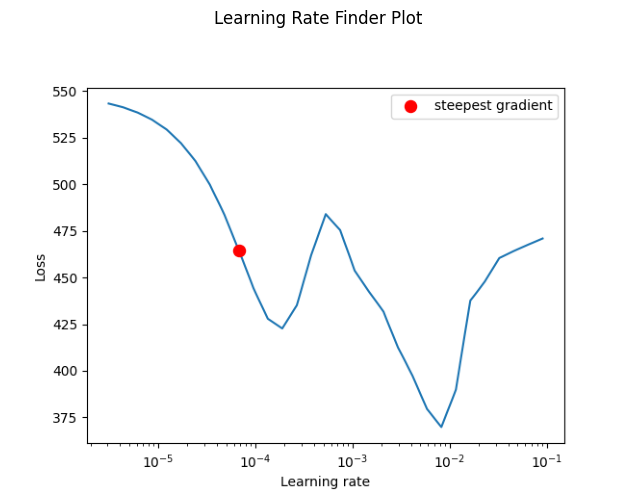

In [189]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [190]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=7e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 13.90 seconds
Best model found at epoch 41/100
Best Train Loss: 1.5562, Best Val Loss: 18.6276
Best Train MSE: 1.5622, Best Val MSE: 19.6153
Best Train RMSE: 1.2499, Best Val RMSE: 4.4289
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-EF_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-EF_Model2/lr_finder_plot.png. Skipping LR finder process.


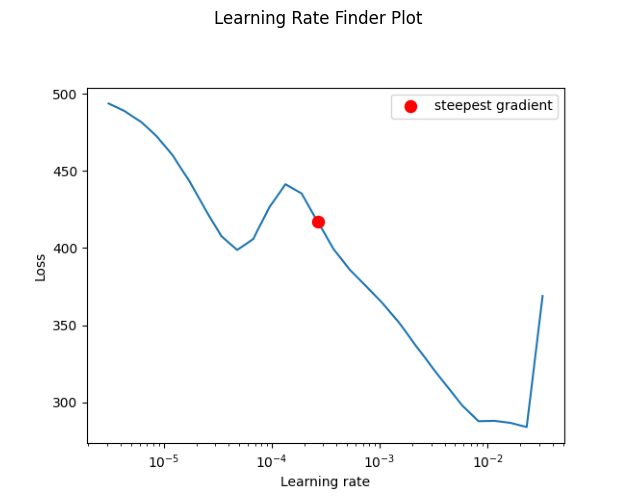

In [191]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [192]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 27.04 seconds
Best model found at epoch 28/100
Best Train Loss: 3.7888, Best Val Loss: 18.9305
Best Train MSE: 3.8340, Best Val MSE: 19.9638
Best Train RMSE: 1.9581, Best Val RMSE: 4.4681
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-EF_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-EF_Model3/lr_finder_plot.png. Skipping LR finder process.


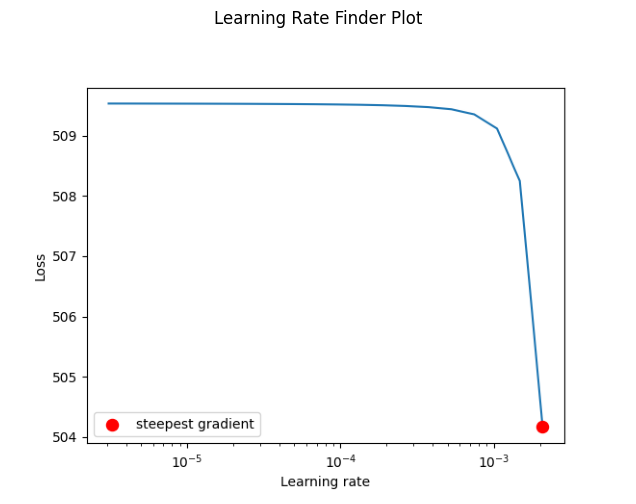

In [193]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [194]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 44.93 seconds
Best model found at epoch 79/100
Best Train Loss: 32.7128, Best Val Loss: 17.8839
Best Train MSE: 32.5113, Best Val MSE: 19.1130
Best Train RMSE: 5.7019, Best Val RMSE: 4.3718
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-EF_Model3/best_model.pth


In [195]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 1.379361207668598, 'train_mse': 1.3791627883911133, 'train_mae': 0.9066294431686401, 'train_rmse': 1.174377617460037, 'train_r2': 0.9836075901985168, 'val_loss': 18.627599239349365, 'val_mse': 19.61530303955078, 'val_mae': 3.597938299179077, 'val_rmse': 4.4289166891634775, 'val_r2': 0.6760258674621582, 'test_loss': 14.809851169586182, 'test_mse': 14.850810050964355, 'test_mae': 3.0344436168670654, 'test_rmse': 3.8536748761363295, 'test_r2': 0.860112190246582, 'min_lr': 1e-05, 'max_lr': 0.007, 'total_time': 13.901928663253784, 'average_epoch_time': 0.1390150308609009}
Model 2 Metrics: {'train_loss': 3.3492210644942064, 'train_mse': 3.354501247406006, 'train_mae': 1.4281883239746094, 'train_rmse': 1.831529756079875, 'train_r2': 0.9601292014122009, 'val_loss': 18.930549144744873, 'val_mse': 19.963760375976562, 'val_mae': 3.3683860301971436, 'val_rmse': 4.46808240478805, 'val_r2': 0.670270562171936, 'test_loss': 15.851584911346436, 'test_mse': 16.63381004333

In [196]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=30, random_seed=SEED)
name = f"SuperTML-VF_FS30"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [197]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-VF_FS30_Model1/lr_finder_plot.png. Skipping LR finder process.


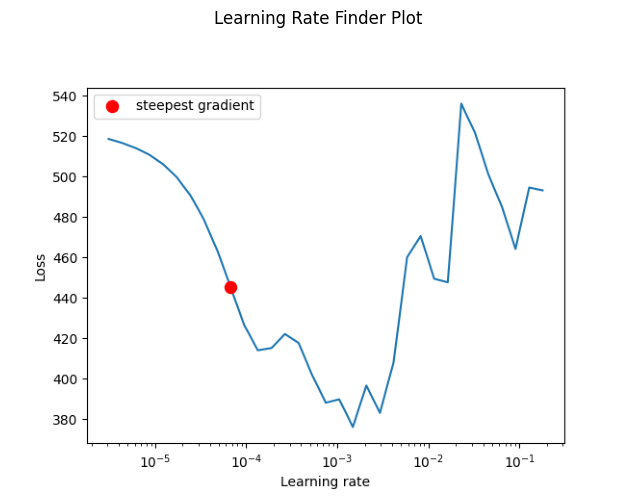

In [198]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [199]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 13.41 seconds
Best model found at epoch 7/100
Best Train Loss: 25.1263, Best Val Loss: 20.8563
Best Train MSE: 24.5800, Best Val MSE: 21.2132
Best Train RMSE: 4.9578, Best Val RMSE: 4.6058
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-VF_FS30_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-VF_FS30_Model2/lr_finder_plot.png. Skipping LR finder process.


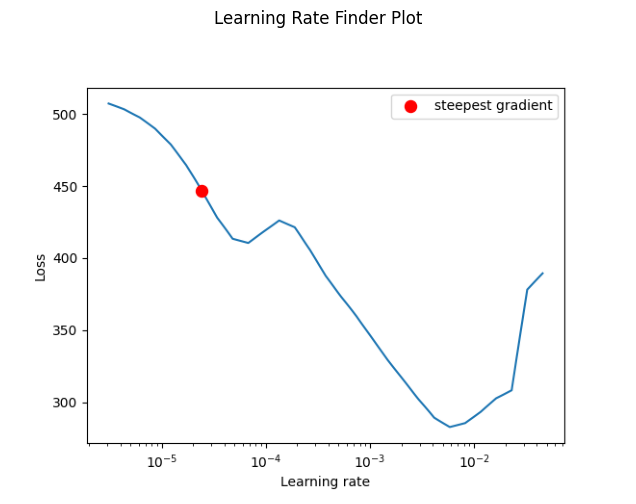

In [200]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [201]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=5e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 26.85 seconds
Best model found at epoch 26/100
Best Train Loss: 14.3126, Best Val Loss: 21.0768
Best Train MSE: 14.0769, Best Val MSE: 22.2779
Best Train RMSE: 3.7519, Best Val RMSE: 4.7199
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-VF_FS30_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-VF_FS30_Model3/lr_finder_plot.png. Skipping LR finder process.


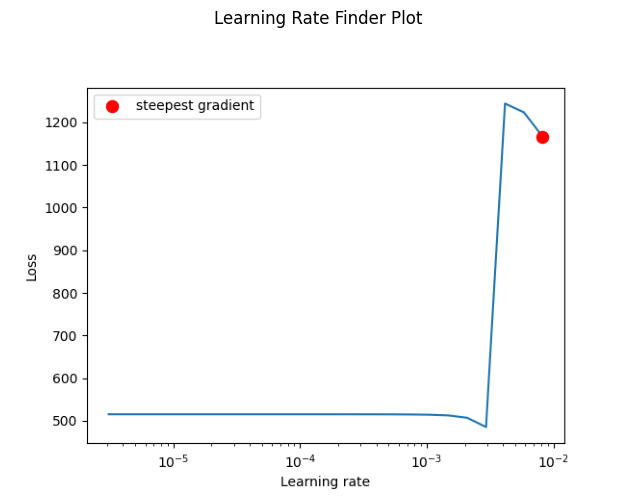

In [202]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [203]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 45.21 seconds
Best model found at epoch 48/100
Best Train Loss: 59.9566, Best Val Loss: 16.7826
Best Train MSE: 60.9042, Best Val MSE: 17.9152
Best Train RMSE: 7.8041, Best Val RMSE: 4.2326
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-VF_FS30_Model3/best_model.pth


In [204]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 21.915510984567497, 'train_mse': 21.62447738647461, 'train_mae': 3.3021883964538574, 'train_rmse': 4.650212617340697, 'train_r2': 0.742976725101471, 'val_loss': 20.856331825256348, 'val_mse': 21.213184356689453, 'val_mae': 3.7381696701049805, 'val_rmse': 4.6057772804044115, 'val_r2': 0.649634599685669, 'test_loss': 183.84200286865234, 'test_mse': 185.2632293701172, 'test_mae': 10.580339431762695, 'test_rmse': 13.611143573194619, 'test_r2': -0.7450945377349854, 'min_lr': 1e-05, 'max_lr': 0.001, 'total_time': 13.40675687789917, 'average_epoch_time': 0.13406306266784668}
Model 2 Metrics: {'train_loss': 9.98475613960853, 'train_mse': 10.091429710388184, 'train_mae': 2.494886875152588, 'train_rmse': 3.1767010735019094, 'train_r2': 0.8800557255744934, 'val_loss': 21.07680320739746, 'val_mse': 22.27786636352539, 'val_mae': 3.7959563732147217, 'val_rmse': 4.719943470373918, 'val_r2': 0.6320499181747437, 'test_loss': 142.39025115966797, 'test_mse': 142.0718383789

In [205]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=70, random_seed=SEED)
name = f"SuperTML-VF_FS70"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [206]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS70/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS70/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS70/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-VF_FS70_Model1/lr_finder_plot.png. Skipping LR finder process.


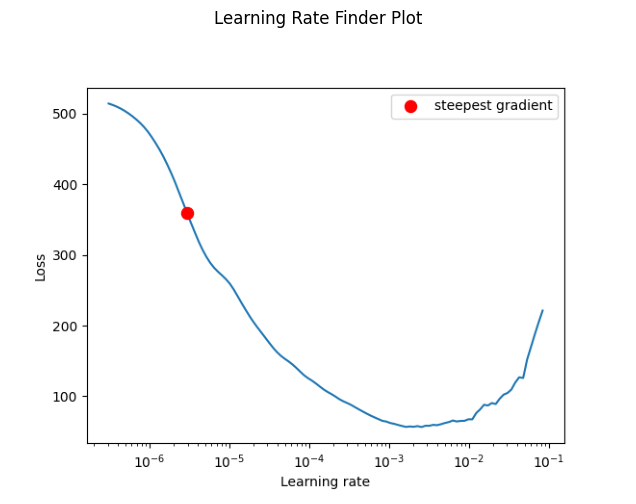

In [207]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=(num_epochs*3))

In [208]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-6, max_lr=2e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 13.23 seconds
Best model found at epoch 49/100
Best Train Loss: 9.5023, Best Val Loss: 27.9806
Best Train MSE: 9.4014, Best Val MSE: 28.2310
Best Train RMSE: 3.0662, Best Val RMSE: 5.3133
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-VF_FS70_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-VF_FS70_Model2/lr_finder_plot.png. Skipping LR finder process.


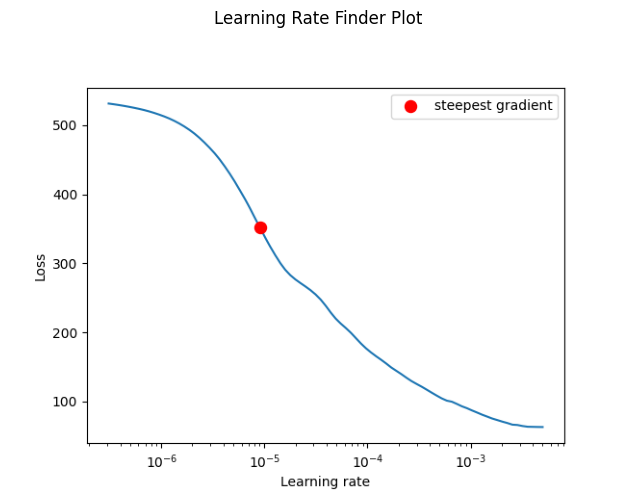

In [209]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=(num_epochs*3))

In [210]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-6, max_lr=2e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 27.50 seconds
Best model found at epoch 20/100
Best Train Loss: 10.2761, Best Val Loss: 20.2958
Best Train MSE: 10.1774, Best Val MSE: 21.6104
Best Train RMSE: 3.1902, Best Val RMSE: 4.6487
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-VF_FS70_Model2/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/SuperTML-VF_FS70_Model3/lr_finder_plot.png. Skipping LR finder process.


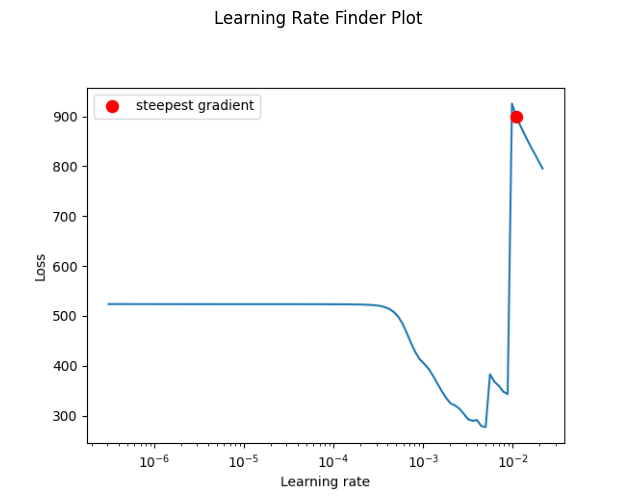

In [211]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=(num_epochs*3))

In [213]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=4e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 44.95 seconds
Best model found at epoch 60/100
Best Train Loss: 37.4334, Best Val Loss: 16.0679
Best Train MSE: 37.7248, Best Val MSE: 17.5654
Best Train RMSE: 6.1421, Best Val RMSE: 4.1911
Best model saved to models/Regression/boston/CNN+MLP/SuperTML-VF_FS70_Model3/best_model.pth


In [214]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 8.05883554311899, 'train_mse': 8.041197776794434, 'train_mae': 2.250253438949585, 'train_rmse': 2.8357005795384027, 'train_r2': 0.9044243097305298, 'val_loss': 27.98059844970703, 'val_mse': 28.231021881103516, 'val_mae': 4.31013298034668, 'val_rmse': 5.313287295178336, 'val_r2': 0.5337252020835876, 'test_loss': 148.21527099609375, 'test_mse': 150.8918914794922, 'test_mae': 9.823147773742676, 'test_rmse': 12.283806066504477, 'test_r2': -0.42133235931396484, 'min_lr': 1e-06, 'max_lr': 0.002, 'total_time': 13.228359699249268, 'average_epoch_time': 0.13227906227111816}
Model 2 Metrics: {'train_loss': 8.768755472623385, 'train_mse': 8.906271934509277, 'train_mae': 2.2567338943481445, 'train_rmse': 2.984337771518043, 'train_r2': 0.894142210483551, 'val_loss': 20.29584503173828, 'val_mse': 21.61042022705078, 'val_mae': 3.5539987087249756, 'val_rmse': 4.648700918219065, 'val_r2': 0.6430736780166626, 'test_loss': 232.23456573486328, 'test_mse': 231.17315673828125

### EXPERIMENT 8: FeatureWrap

In [215]:
#Select the model and the parameters
problem_type = "regression"
image_model = FeatureWrap(problem = problem_type, bins=10)
name = f"FeatureWrap"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [216]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_FeatureWrap/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_FeatureWrap/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_FeatureWrap/test/regression.csv
Images shape:  (3, 8, 8)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/FeatureWrap_Model1/lr_finder_plot.png. Skipping LR finder process.


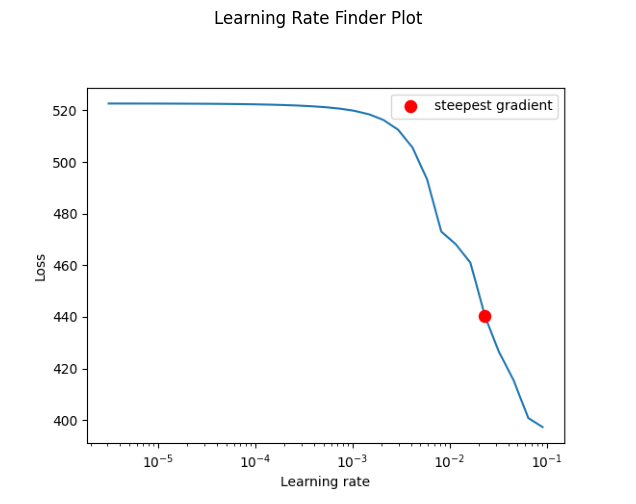

In [217]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [218]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.38 seconds
Best model found at epoch 16/100
Best Train Loss: 29.5368, Best Val Loss: 29.0328
Best Train MSE: 29.3026, Best Val MSE: 29.6325
Best Train RMSE: 5.4132, Best Val RMSE: 5.4436
Best model saved to models/Regression/boston/CNN+MLP/FeatureWrap_Model1/best_model.pth


LR finder plot already exists at logs/Regression/boston/CNN+MLP/FeatureWrap_Model2/lr_finder_plot.png. Skipping LR finder process.


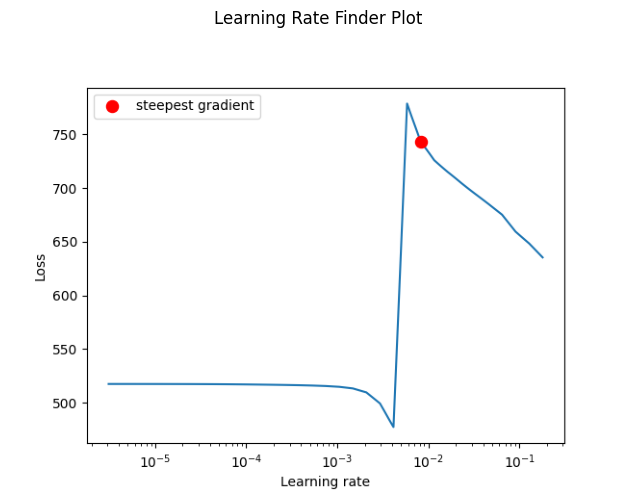

In [219]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [221]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-4, max_lr=3e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.13 seconds
Best model found at epoch 83/100
Best Train Loss: 6.1485, Best Val Loss: 15.0605
Best Train MSE: 6.2248, Best Val MSE: 15.0941
Best Train RMSE: 2.4950, Best Val RMSE: 3.8851
Best model saved to models/Regression/boston/CNN+MLP/FeatureWrap_Model2/best_model.pth


In [222]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [223]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Error creating or testing Model3:
Model FeatureWrap_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [224]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 22.469094056349533, 'train_mse': 22.300809860229492, 'train_mae': 3.6463429927825928, 'train_rmse': 4.722373329188353, 'train_r2': 0.7349380254745483, 'val_loss': 29.032848358154297, 'val_mse': 29.63251304626465, 'val_mae': 4.4709086418151855, 'val_rmse': 5.443575391804972, 'val_r2': 0.5105776190757751, 'test_loss': 22.93519926071167, 'test_mse': 26.292236328125, 'test_mae': 3.678541660308838, 'test_rmse': 5.127595569867518, 'test_r2': 0.752339243888855, 'min_lr': 0.001, 'max_lr': 0.1, 'total_time': 4.383405447006226, 'average_epoch_time': 0.04383218288421631}
Model 2 Metrics: {'train_loss': 5.359694004058838, 'train_mse': 5.418250560760498, 'train_mae': 1.5585699081420898, 'train_rmse': 2.3277135907925826, 'train_r2': 0.9355999827384949, 'val_loss': 15.06047534942627, 'val_mse': 15.094111442565918, 'val_mae': 2.764308452606201, 'val_rmse': 3.885114083597278, 'val_r2': 0.7506996393203735, 'test_loss': 18.974262475967407, 'test_mse': 22.204648971557617, '

### EXPERIMENT 9: BIE

In [225]:
#Select the model and the parameters
problem_type = "regression"
image_model = BIE(problem = problem_type)
name = f"BIE"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [226]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
./HyNNImages/Regression/boston/images_boston_BIE/train/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BIE/val/regression.csv
The images are already generated
./HyNNImages/Regression/boston/images_boston_BIE/test/regression.csv
Images shape:  (3, 13, 32)
Attributes:  13


LR finder plot already exists at logs/Regression/boston/CNN+MLP/BIE_Model1/lr_finder_plot.png. Skipping LR finder process.


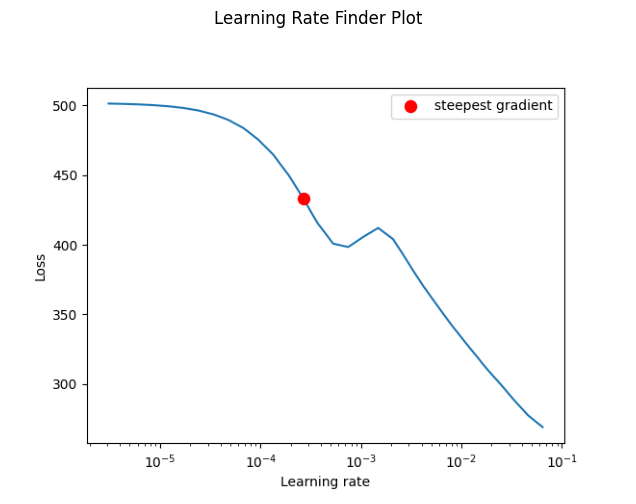

In [227]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [228]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=6e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.87 seconds
Best model found at epoch 15/100
Best Train Loss: 9.9761, Best Val Loss: 25.6870
Best Train MSE: 9.7253, Best Val MSE: 29.7475
Best Train RMSE: 3.1185, Best Val RMSE: 5.4541
Best model saved to models/Regression/boston/CNN+MLP/BIE_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-04


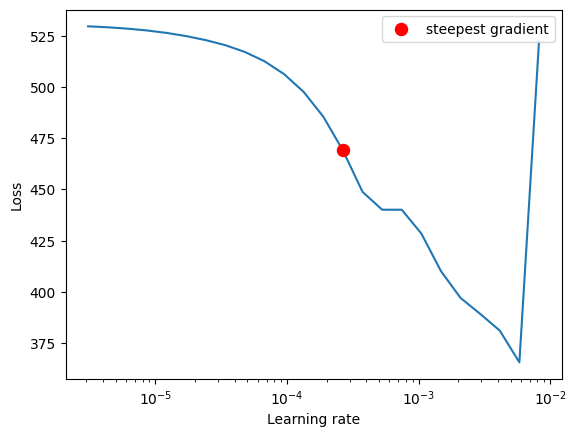

Plot saved to: logs/Regression/boston/CNN+MLP/BIE_Model2/lr_finder_plot.png
Suggested learning rate: 0.00026639858572587714


In [229]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [230]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.09 seconds
Best model found at epoch 36/100
Best Train Loss: 1.1834, Best Val Loss: 15.8233
Best Train MSE: 1.1673, Best Val MSE: 17.5866
Best Train RMSE: 1.0804, Best Val RMSE: 4.1936
Best model saved to models/Regression/boston/CNN+MLP/BIE_Model2/best_model.pth


In [231]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3:


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [232]:
# Create and train Model3
model3 = try_create_model(Model3, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Error creating or testing Model3:
Model BIE_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_19806/1974695419.py", line 5, in try_create_model
    model = model_class(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 141, in __init__
    self.cnn_size = self._get_cnn_size(attributes, imgs_shape)
  File "/tmp/ipykernel_19806/3316971769.py", line 207, in _get_cnn_size
    branch_1_out = self.branch_1(dummy_cnn_input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/c

In [233]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 6.521855170910175, 'train_mse': 6.481544494628906, 'train_mae': 2.013885736465454, 'train_rmse': 2.5458877615929785, 'train_r2': 0.922961950302124, 'val_loss': 25.68702983856201, 'val_mse': 29.74745750427246, 'val_mae': 3.9640820026397705, 'val_rmse': 5.454122982136767, 'val_r2': 0.5086791515350342, 'test_loss': 37.403398513793945, 'test_mse': 40.59899139404297, 'test_mae': 4.451364517211914, 'test_rmse': 6.371733782420839, 'test_r2': 0.6175761222839355, 'min_lr': 1e-05, 'max_lr': 0.06, 'total_time': 4.8735878467559814, 'average_epoch_time': 0.04873271465301514}
Model 2 Metrics: {'train_loss': 1.2649830671457143, 'train_mse': 1.2769584655761719, 'train_mae': 0.843218982219696, 'train_rmse': 1.1300258694278515, 'train_r2': 0.9848223924636841, 'val_loss': 15.82330322265625, 'val_mse': 17.586637496948242, 'val_mae': 2.9398019313812256, 'val_rmse': 4.193642509435949, 'val_r2': 0.7095320820808411, 'test_loss': 22.030896186828613, 'test_mse': 24.07046890258789

## FINAL METRICS AND BEST MODEL

In [234]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [235]:
import os

def read_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split(': ')
            metrics[key.strip()] = float(value.strip())
    return metrics

def rename_folder(old_folder_path, prefix):
    folder_name = os.path.basename(old_folder_path)
    new_folder_name = f"{prefix}_{folder_name}"
    parent_dir = os.path.dirname(old_folder_path)
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    os.rename(old_folder_path, new_folder_path)
    return new_folder_path

def process_folders(root_dir):
    prefixes = ["TINTO", "BarGraph", "Combination", "DistanceMatrix", "IGTD", "REFINED", "SuperTML", "FeatureWrap"]
    best_folders = []

    for prefix in prefixes:
        matching_folders = [f for f in os.listdir(root_dir) if f.startswith(prefix) and os.path.isdir(os.path.join(root_dir, f))]
        if matching_folders:
            best_folder = None
            best_test_rmse = float('inf')
            for folder in matching_folders:
                metrics_file = os.path.join(root_dir, folder, 'metrics.txt')
                if os.path.exists(metrics_file):
                    metrics = read_metrics(metrics_file)
                    if metrics['test_rmse'] < best_test_rmse:
                        best_test_rmse = metrics['test_rmse']
                        best_folder = folder
            if best_folder:
                new_path = rename_folder(os.path.join(root_dir, best_folder), "TOP")
                best_folders.append(new_path)
    
    if best_folders:
        overall_best_folder = None
        overall_best_test_rmse = float('inf')
        for folder in best_folders:
            metrics_file = os.path.join(folder, 'metrics.txt')
            if os.path.exists(metrics_file):
                metrics = read_metrics(metrics_file)
                if metrics['test_rmse'] < overall_best_test_rmse:
                    overall_best_test_rmse = metrics['test_rmse']
                    overall_best_folder = folder
        if overall_best_folder:
            rename_folder(overall_best_folder, "BEST")
        
    return best_folders

In [236]:
# Usage
base_path = f"logs/Regression/{dataset_name}/CNN+MLP/"
best_folders = process_folders(base_path)
print(f"Best model folder: {best_folders}")

Best model folder: ['logs/Regression/boston/CNN+MLP/TOP_TINTO_Model3', 'logs/Regression/boston/CNN+MLP/TOP_BarGraph_zoom4_Model3', 'logs/Regression/boston/CNN+MLP/TOP_Combination_Model2', 'logs/Regression/boston/CNN+MLP/TOP_DistanceMatrix_zoom4_Model1', 'logs/Regression/boston/CNN+MLP/TOP_IGTD_16x16_fEuclidean_iEuclidean_abs_Model2', 'logs/Regression/boston/CNN+MLP/TOP_REFINED_Model2', 'logs/Regression/boston/CNN+MLP/TOP_SuperTML-VF_FS30_Model3', 'logs/Regression/boston/CNN+MLP/TOP_FeatureWrap_Model2']


### To Excel

In [237]:
def extract_metrics(directory):
    data = []

    # Walk through the directory
    for root, _, files in os.walk(directory):
        if "metrics.txt" in files:
            file_path = os.path.join(root, "metrics.txt")

            # Extract folder name
            folder_name = os.path.relpath(root, directory)

            # Read metrics.txt
            with open(file_path, "r") as file:
                metrics = {}
                for line in file:
                    key, value = line.strip().split(":")
                    metrics[key.strip()] = float(value.strip()) if value.strip().replace('.', '', 1).isdigit() else value.strip()

            # Add folder name to metrics
            metrics["folder_name"] = folder_name
            data.append(metrics)

    return data

In [238]:
def save_to_excel(data, output_file):
    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Reorder columns to start with folder_name
    columns = ["folder_name"] + [col for col in df.columns if col != "folder_name"]
    df = df[columns]

    # Save to Excel
    df.to_excel(output_file, index=False)

In [ ]:
input_directory = "Jiayun/TINTOlib/logs/Regression"  # Change this to your directory
output_file = "metrics_summary.xlsx"

# Extract metrics
metrics_data = extract_metrics(input_directory)

# Save metrics to Excel
save_to_excel(metrics_data, output_file)
print(f"Metrics summary saved to {output_file}")